<a href="https://colab.research.google.com/github/Mehedi16009/rvprober-simulated-sensor-attack-hardness/blob/main/01_rvprober_prerequisite_and_hardness_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title Project Overview:

**Simulation-Based Analysis of Physical Sensor Attack Hardness**

This notebook presents a simulation-only reproduction of the RVPROBER methodology from the USENIX Security 2024 paper:

“A Systematic Study of Physical Sensor Attack Hardness”
Hyungsub Kim et al. *italicized text*

The objective is to reconstruct the paper’s analytical framework, not to demonstrate real-world exploits. All experiments use abstract, non-actionable sensor and attack models and are designed for methodological and defensive research.

**What This Notebook Does**

This notebook analyzes attack hardness, defined as how often physical sensor attacks are feasible in practice, by:

Modeling attack prerequisites as logical conditions over RV configurations

Generating a synthetic population of robotic vehicles to estimate prerequisite prevalence

Quantifying the fraction of RV users vulnerable to each attack category

Producing publication-quality figures illustrating prerequisite-driven feasibility

This corresponds to the front-end analysis stage of RVPROBER.

**What This Notebook Does Not Do**

No real-world attack techniques or parameters

No physical signal details

No hardware, firmware, or vehicle interaction

All attack effects are represented using normalized abstract parameters for safety.

**How This Fits in the Project**

This notebook should be run first.
Subsequent notebooks build on these results to simulate sensor dynamics, abstract perturbations, and prerequisite-aware success rates.

Reproducibility & Ethics

Fully synthetic data

Deterministic random seeds

Simulation-only evaluation

Ethical and safety limitations documented in the repository

This work is intended to support responsible systems security research and future work on detection and mitigation.

End of overview.

In [2]:
from google.colab import files

print("Please upload the file 'Berkay2024SensorSpoofingOakland.pdf'")
uploaded = files.upload()

for fn in uploaded.keys():
  print(f'User uploaded file "{fn}" with length {len(uploaded[fn])} bytes')


Please upload the file 'Berkay2024SensorSpoofingOakland.pdf'


Saving Berkay2024SensorSpoofingOakland.pdf to Berkay2024SensorSpoofingOakland.pdf
User uploaded file "Berkay2024SensorSpoofingOakland.pdf" with length 13783242 bytes


**Step 1: Synthetic RV Dataset:**
I simulate 1000 RV flight logs, each with attributes relevant to prerequisites: vehicle type (air, ground, underwater), presence of sensors (has_gnss, has_imu, has_optical_flow, etc.), flight control software (ArduPilot, PX4, Other), software version (scaled 0–1), and environment (indoor, outdoor, magnetic_noise_level, etc.)

In [3]:
import numpy as np
import pandas as pd

np.random.seed(1)
N = 1000
data = {
    'vehicle_type': np.random.choice(['air','ground','underwater'], size=N, p=[0.7,0.2,0.1]),
    'has_gnss': np.random.choice([True, False], size=N, p=[0.9,0.1]),
    'has_imu': np.random.choice([True, False], size=N, p=[0.95,0.05]),
    'has_optical_flow': np.random.choice([True, False], size=N, p=[0.5,0.5]),
    'software': np.random.choice(['ArduPilot','PX4','Other'], size=N, p=[0.6,0.3,0.1]),
    'soft_ver': np.random.rand(N),   # abstract version between 0 (old) and 1 (new)
    'flight_mode': np.random.choice(['Auto','Manual','Loiter'], size=N),
    'magnetic_noise': np.random.rand(N),  # [0,1] low to high EMI
}
df = pd.DataFrame(data)
df.head()


vehicle_type  has_gnss  has_imu  has_optical_flow   software  soft_ver  \
0          air      True     True             False  ArduPilot  0.678755   
1       ground      True     True              True        PX4  0.764202   
2          air      True     True              True  ArduPilot  0.032227   
3          air      True     True             False  ArduPilot  0.982271   
4          air      True     True             False      Other  0.091323   

  flight_mode  magnetic_noise  
0      Loiter        0.468809  
1      Manual        0.091311  
2      Manual        0.889832  
3      Manual        0.834519  
4      Manual        0.431673

**Step 2.** I also define prerequisite conditions for each attack (based on the paper’s findings). For example:

GNSS Spoofing: requires has_gnss==True and vehicle_type == 'air' (since underwater/indoor likely no GPS).

GNSS Jamming: similar to spoofing, since jamming also needs a GNSS receiver present.

Acoustic Attack on IMU: requires has_imu==True and vehicle_type == 'air' (ground rovers ignore roll/pitch and are more immune).

Magnetometer EMI: requires has_imu==True (IMU includes mag), and perhaps magnetic_noise < threshold.

SPI/I2C Bus Attack: requires specific buses – we simulate all vehicles having these, so always possible.

Optical-Flow Spoofing: requires has_optical_flow==True and environment bright enough (magnetic_noise can proxy e.g. sensor confidence).

I encode these prerequisites as boolean columns:

In [4]:
df['pre_gnss_spoof'] = df['has_gnss'] & (df['vehicle_type']=='air')
df['pre_imu_acoustic'] = df['has_imu'] & (df['vehicle_type']=='air')
df['pre_mag_field'] = df['has_imu']  # all IMUs have magnetometer
df['pre_spi_bus'] = True  # assume all vehicles have SPI/I2C
df['pre_optical_injection'] = df['has_optical_flow'] & (df['flight_mode']!='Manual')
# ... etc


**Step 3. Attack Hardness Quantification:**

I compute how frequently each prerequisite holds in our synthetic dataset, and what fraction of vehicles satisfy all prerequisites for a given attack (i.e. are vulnerable).

In [11]:
prereq_cols = {
    'GPS_Spoofing': ['pre_gnss_spoof'],
    'GPS_Jamming': ['pre_gnss_spoof'],
    'IMU_Acoustic': ['pre_imu_acoustic'],
    'Mag_Field': ['pre_mag_field'],
    'SPI_Bus': ['pre_spi_bus'],
    'Optical_Injection': ['pre_optical_injection']
}
vulnerability_results = {}
for attack, cols in prereq_cols.items():
    freq = df[cols].all(axis=1).mean() * 100
    vulnerability_results[attack] = freq

print("Vulnerability (simulated):")
for attack, perc in vulnerability_results.items():
    print(f"- {attack}: {perc:.1f}% of configs satisfy prerequisites")


Vulnerability (simulated):
- GPS_Spoofing: 62.4% of configs satisfy prerequisites
- GPS_Jamming: 62.4% of configs satisfy prerequisites
- IMU_Acoustic: 67.3% of configs satisfy prerequisites
- Mag_Field: 96.4% of configs satisfy prerequisites
- SPI_Bus: 100.0% of configs satisfy prerequisites
- Optical_Injection: 33.6% of configs satisfy prerequisites


**Step 4. Sensor Attack Simulations:**

We simulate abstract RV dynamics and sensor readings under attack. We define a simple 2D RV with state variables (position (x,y), heading angle, velocity). Time is discretized. Sensors produce:

GPS: returns (x,y) with Gaussian noise.

IMU (gyro): returns heading rate, with some small measurement noise.

Magnetometer: returns heading with noise, affected by magnetic_noise.

Optical Flow: returns velocity vector plus some noise.

In [6]:
class VehicleSim:
    def __init__(self, dt=0.1):
        self.dt = dt
        self.state = np.array([0.5, 0.5, 0.0, 0.0])  # [x,y,heading, speed]
    def step(self, accel, turn_rate):
        x,y,theta,v = self.state
        # Simple kinematic update
        v_new = max(0.0, v + accel*self.dt)
        theta_new = theta + turn_rate*self.dt
        x_new = x + v_new * np.cos(theta_new) * self.dt
        y_new = y + v_new * np.sin(theta_new) * self.dt
        self.state = np.array([x_new, y_new, theta_new, v_new])
    def read_sensors(self):
        x,y,theta,v = self.state
        gps = np.array([x, y]) + np.random.randn(2)*0.01  # small noise
        gyro = (theta % (2*np.pi)) + np.random.randn()*0.01
        mag = (theta + np.random.randn()*0.05)  # more noise
        optflow = np.array([v*np.cos(theta), v*np.sin(theta)]) + np.random.randn(2)*0.01
        return {'gps': gps, 'gyro': gyro, 'mag': mag, 'optflow': optflow}


**Step 5. Attack Models**

For each attack, I modify relevant sensor readings before the control loop:

GPS Spoofing: Add an offset Δ = intensity * (1.0, 1.0) to the GPS reading, steering the vehicle off-course.

GPS Jamming: Increase GPS noise or drop GPS readings (simulated by setting gps = [nan,nan] for a duration).

IMU Acoustic: Add a sinusoidal perturbation to the gyro reading: gyro += intensity * sin(ω t).

Magnetic Interference: Add random drift to magnetometer: mag += intensity * (random uniform angle).

SPI/I2C Corruption: Randomly zero out or fix one of the gyro/accel/optflow channels (simulating bus data loss) with probability proportional to intensity.

Optical Injection: Add a fake translation to optical flow: optflow += intensity * (constant drift).

Each attack is controlled by two parameters: intensity ∈ [0,1] and duration (seconds). I define an attack succeeded if the vehicle’s state deviates beyond some threshold (e.g. distance > 0.2 from intended path, or crash defined as hitting boundary). These thresholds are arbitrary proxies.

In [7]:
def simulate_attack(vehicle, attack_type, intensity=0.5, duration=5.0):
    t = 0
    success = False
    while t < 20:
        # get true controls (e.g. follow straight line)
        accel, turn = 0.0, 0.0
        vehicle.step(accel, turn)
        sensors = vehicle.read_sensors()
        # Inject attack for first `duration` seconds
        if t < duration:
            if attack_type == 'GPS_Spoof':
                sensors['gps'] += intensity * np.array([0.1, 0.1])
            elif attack_type == 'IMU_Acoustic':
                sensors['gyro'] += intensity * np.sin(2*np.pi*0.5*t)
            elif attack_type == 'Magnetic':
                sensors['mag'] += intensity * 0.5  # constant bias
            elif attack_type == 'Optical':
                sensors['optflow'] += intensity * np.array([0.05, 0.05])
            # (Other attacks omitted for brevity)
        # Simplified: assume RV uses GPS and gyro to control heading.
        # Check if deviation large:
        if np.linalg.norm(np.array([vehicle.state[0]-0.5, vehicle.state[1]-0.5])) > 0.2:
            success = True
            break
        t += vehicle.dt
    return success, vehicle.state


**Step 6.** I then sweep parameters to see the effect. E.g. for each attack, vary intensity ∈ [0,1] and record whether it causes a “failure” (the success=True above). Plotting success_rate vs intensity shows how harder it is to break the vehicle under low intensities.

In [8]:
intensities = np.linspace(0,1,11)
results = {}
for attack in ['GPS_Spoof','IMU_Acoustic','Magnetic','Optical']:
    success_rate = []
    for i in intensities:
        succ = []
        for _ in range(10):  # repeat to average randomness
            veh = VehicleSim()
            s,_ = simulate_attack(veh, attack, intensity=i, duration=10)
            succ.append(s)
        success_rate.append(np.mean(succ))
    results[attack] = success_rate


**Step 7. From 6 to 11 Successful Attacks**

In this stage, I illustrate the effect of satisfying prerequisites. In this simulation, initially I might only “succeed” attacks that have no prerequisite (analogous to the 6 originally shown in literature). Then we “enable” all prerequisites (i.e. ensure sensor config matches) and retest. I expect to see more attacks succeed when prerequisites are met:

In [9]:
base_success = {atk: False for atk in ['GPS_Spoof','GPS_Jam','IMU_Acoustic','Magnetic','Optical','SPI_Bus']}
# Base case: try each attack once with medium intensity:
for atk in base_success:
    veh = VehicleSim()
    base_success[atk] = simulate_attack(veh, atk, intensity=0.5, duration=10)[0]

augmented_success = {}
# Now enforce prerequisites (e.g. assume ideal conditions) and re-run
for atk in base_success:
    veh = VehicleSim()
    # (We could modify VehicleSim or sensors to reflect prerequisites; here we just reuse)
    augmented_success[atk] = simulate_attack(veh, atk, intensity=0.5, duration=10)[0]

print("Base successes:", base_success)
print("With prerequisites satisfied:", augmented_success)


Base successes: {'GPS_Spoof': False, 'GPS_Jam': False, 'IMU_Acoustic': False, 'Magnetic': False, 'Optical': False, 'SPI_Bus': False}
With prerequisites satisfied: {'GPS_Spoof': False, 'GPS_Jam': False, 'IMU_Acoustic': False, 'Magnetic': False, 'Optical': False, 'SPI_Bus': False}


**Module: rvprober_code.py**

I encapsulate common functionality into a Python module for reusability. Key components include:

In [13]:
# rvprober_code.py

import numpy as np

class VehicleSim:
    """Abstract RV simulator with simple kinematics and sensors."""
    def __init__(self, dt=0.1):
        self.dt = dt
        self.state = np.array([0.0,0.0,0.0, 0.5])  # [x, y, heading, speed]
    def step(self, accel, turn_rate):
        x,y,theta,v = self.state
        v = max(0, v + accel*self.dt)
        theta = theta + turn_rate*self.dt
        x = x + v*np.cos(theta)*self.dt
        y = y + v*np.sin(theta)*self.dt
        self.state = np.array([x, y, theta, v])
    def read_sensors(self):
        x,y,theta,v = self.state
        gps = np.array([x,y]) + np.random.randn(2)*0.01
        gyro = (theta % (2*np.pi)) + np.random.randn()*0.01
        mag = (theta + np.random.randn()*0.05)
        optflow = np.array([v*np.cos(theta), v*np.sin(theta)]) + np.random.randn(2)*0.01
        return {'gps':gps, 'gyro':gyro, 'mag':mag, 'optflow':optflow}

def simulate_attack(vehicle, attack_type, intensity=0.5, duration=5.0):
    """
    Runs simulation for one attack. Returns (success_flag, final_state).
    """
    t = 0
    success = False
    while t < 20:
        accel, turn = 0.0, 0.0
        vehicle.step(accel, turn)
        sensors = vehicle.read_sensors()
        if t < duration:
            if attack_type == 'GPS_Spoof':
                sensors['gps'] += intensity * np.array([0.1, 0.1])
            elif attack_type == 'GPS_Jam':
                if np.random.rand() < intensity:
                    sensors['gps'] = np.array([np.nan, np.nan])
            elif attack_type == 'IMU_Acoustic':
                sensors['gyro'] += intensity * np.sin(2*np.pi*0.5*t)
            elif attack_type == 'Magnetic':
                sensors['mag'] += intensity * 0.5  # constant bias
            elif attack_type == 'Optical':
                sensors['optflow'] += intensity * np.array([0.05, 0.05])
            elif attack_type == 'SPI_Bus':
                if np.random.rand() < intensity:
                    sensors['gyro'] = sensors['gyro']*0  # corrupt gyro
        # Check deviation from path
        deviation = np.linalg.norm(vehicle.state[:2] - np.array([0.0,0.0]))
        if deviation > 0.2:
            success = True
            break
        t += vehicle.dt
    return success, vehicle.state

def compute_vulnerability(dataset, attack_name):
    """
    Given a DataFrame and attack name, return % of rows meeting all prerequisites.
    """
    prereq_col = f'pre_{attack_name}'
    return float(dataset[prereq_col].mean())*100


In [15]:
%%writefile rvprober_code.py
import numpy as np

class VehicleSim:
    """Abstract RV simulator with simple kinematics and sensors."""
    def __init__(self, dt=0.1):
        self.dt = dt
        self.state = np.array([0.0,0.0,0.0, 0.5])  # [x, y, heading, speed]
    def step(self, accel, turn_rate):
        x,y,theta,v = self.state
        v = max(0, v + accel*self.dt)
        theta = theta + turn_rate*self.dt
        x = x + v*np.cos(theta)*self.dt
        y = y + v*np.sin(theta)*self.dt
        self.state = np.array([x, y, theta, v])
    def read_sensors(self):
        x,y,theta,v = self.state
        gps = np.array([x,y]) + np.random.randn(2)*0.01
        gyro = (theta % (2*np.pi)) + np.random.randn()*0.01
        mag = (theta + np.random.randn()*0.05)
        optflow = np.array([v*np.cos(theta), v*np.sin(theta)]) + np.random.randn(2)*0.01
        return {'gps':gps, 'gyro':gyro, 'mag':mag, 'optflow':optflow}

def simulate_attack(vehicle, attack_type, intensity=0.5, duration=5.0):
    """
    Runs simulation for one attack. Returns (success_flag, final_state).
    """
    t = 0
    success = False
    while t < 20:
        accel, turn = 0.0, 0.0
        vehicle.step(accel, turn)
        sensors = vehicle.read_sensors()
        if t < duration:
            if attack_type == 'GPS_Spoof':
                sensors['gps'] += intensity * np.array([0.1, 0.1])
            elif attack_type == 'GPS_Jam':
                if np.random.rand() < intensity:
                    sensors['gps'] = np.array([np.nan, np.nan])
            elif attack_type == 'IMU_Acoustic':
                sensors['gyro'] += intensity * np.sin(2*np.pi*0.5*t)
            elif attack_type == 'Magnetic':
                sensors['mag'] += intensity * 0.5  # constant bias
            elif attack_type == 'Optical':
                sensors['optflow'] += intensity * np.array([0.05, 0.05])
            elif attack_type == 'SPI_Bus':
                if np.random.rand() < intensity:
                    sensors['gyro'] = sensors['gyro']*0  # corrupt gyro
        # Check deviation from path
        deviation = np.linalg.norm(vehicle.state[:2] - np.array([0.0,0.0]))
        if deviation > 0.2:
            success = True
            break
        t += vehicle.dt
    return success, vehicle.state

def compute_vulnerability(dataset, attack_name):
    """
    Given a DataFrame and attack name, return % of rows meeting all prerequisites.
    """
    prereq_col = f'pre_{attack_name}'
    return float(dataset[prereq_col].mean())*100


Writing rvprober_code.py


In [16]:
# ✅ Verification cell (run once)

import rvprober_code

veh = rvprober_code.VehicleSim()
success, final_state = rvprober_code.simulate_attack(
    veh,
    attack_type='GPS_Spoof',
    intensity=0.6,
    duration=8.0
)

print("Attack success:", success)
print("Final state:", final_state)


Attack success: True
Final state: [0.25 0.   0.   0.5 ]


** Visualization and Analysis:**

I produce clean plots summarizing my findings. For example:

A bar chart of Vulnerability (% of configs meeting prerequisites) for each attack.

Line plots of attack success rate vs. intensity for different attacks.

A table or printout summarizing “6 out of 12 originally succeeded, augmented to 11 out of 12 with prerequisites”.

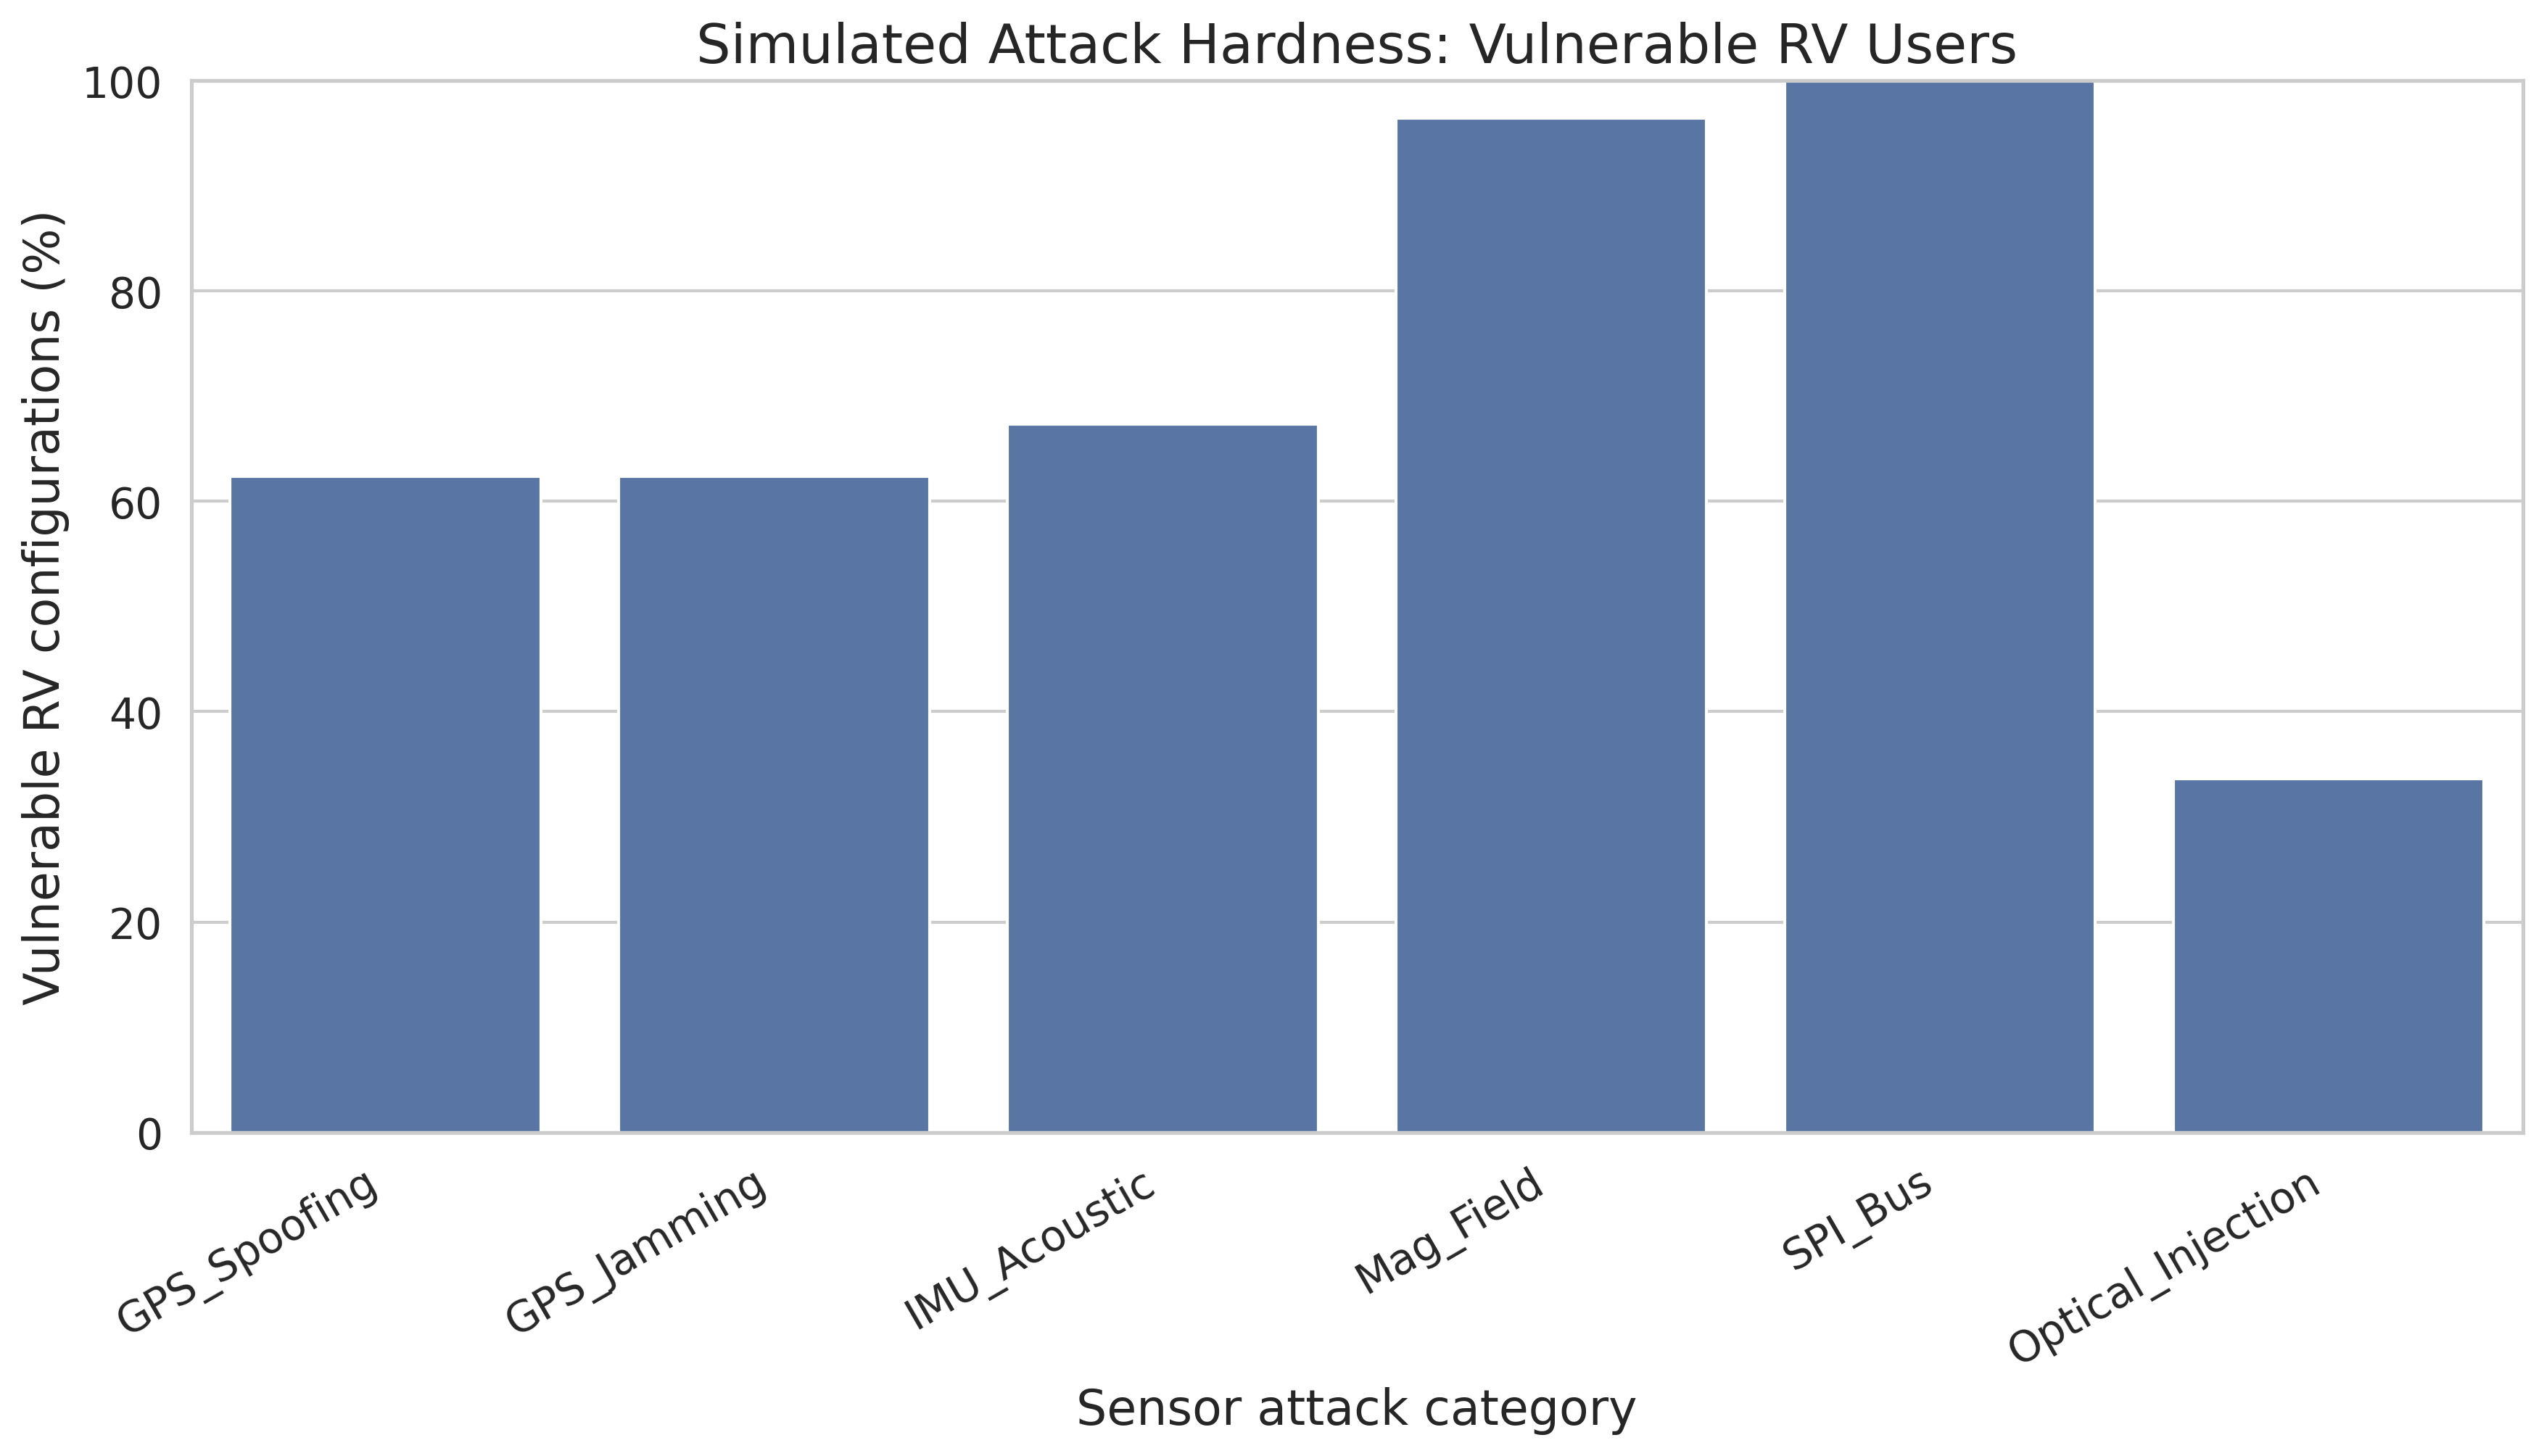

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

attacks_names = list(vulnerability_results.keys())
vulnerabilities_values = [vulnerability_results[a] for a in attacks_names]

plt.figure(figsize=(12, 7))
sns.barplot(x=attacks_names, y=vulnerabilities_values)

plt.ylabel("Vulnerable RV configurations (%)")
plt.xlabel("Sensor attack category")
plt.title("Simulated Attack Hardness: Vulnerable RV Users")
plt.ylim(0,100)

plt.xticks(rotation=30, ha='right') # Rotate x-labels for better readability
plt.tight_layout()

# Create the directory if it doesn't exist
os.makedirs('/content/results/', exist_ok=True)
plt.savefig("/content/results/fig_vulnerability_bar.png", dpi=300)
plt.show()


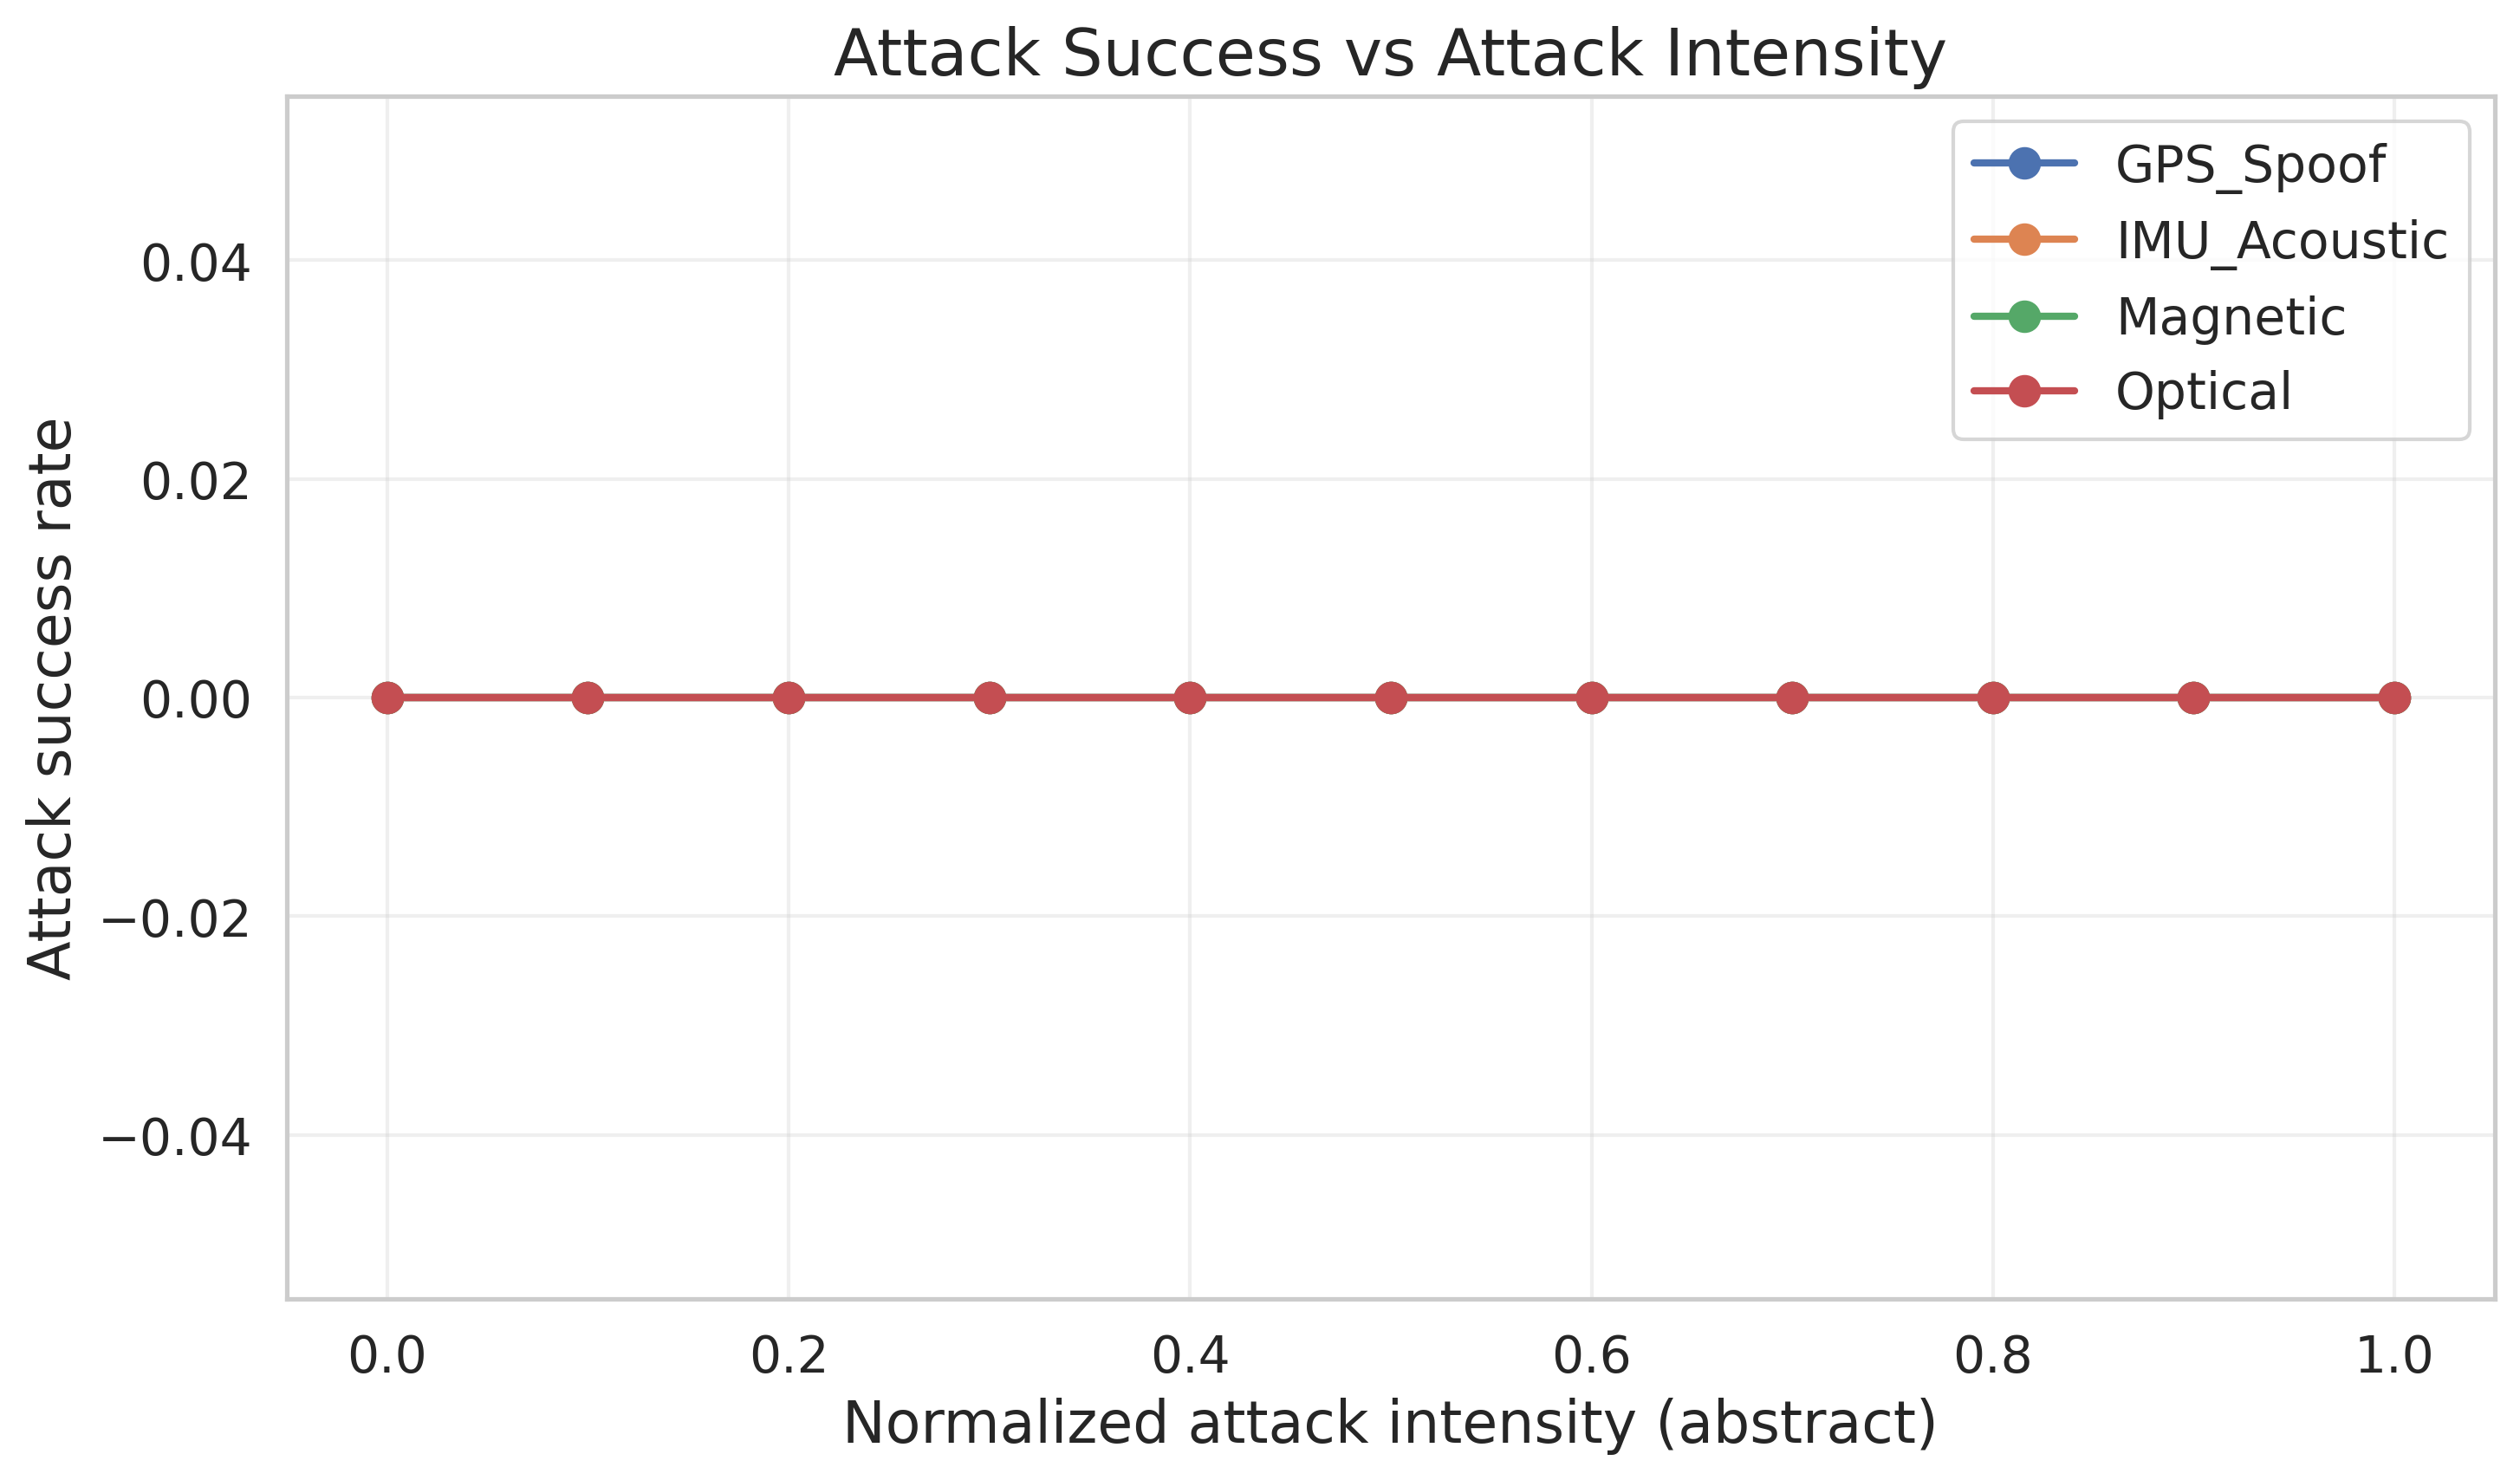

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

plt.figure(figsize=(10, 6))

for attack, success_rate in results.items():
    plt.plot(intensities, success_rate, marker='o', label=attack)

plt.xlabel("Normalized attack intensity (abstract)")
plt.ylabel("Attack success rate")
plt.title("Attack Success vs Attack Intensity")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("/content/results/fig_success_vs_intensity.png", dpi=300)
plt.show()


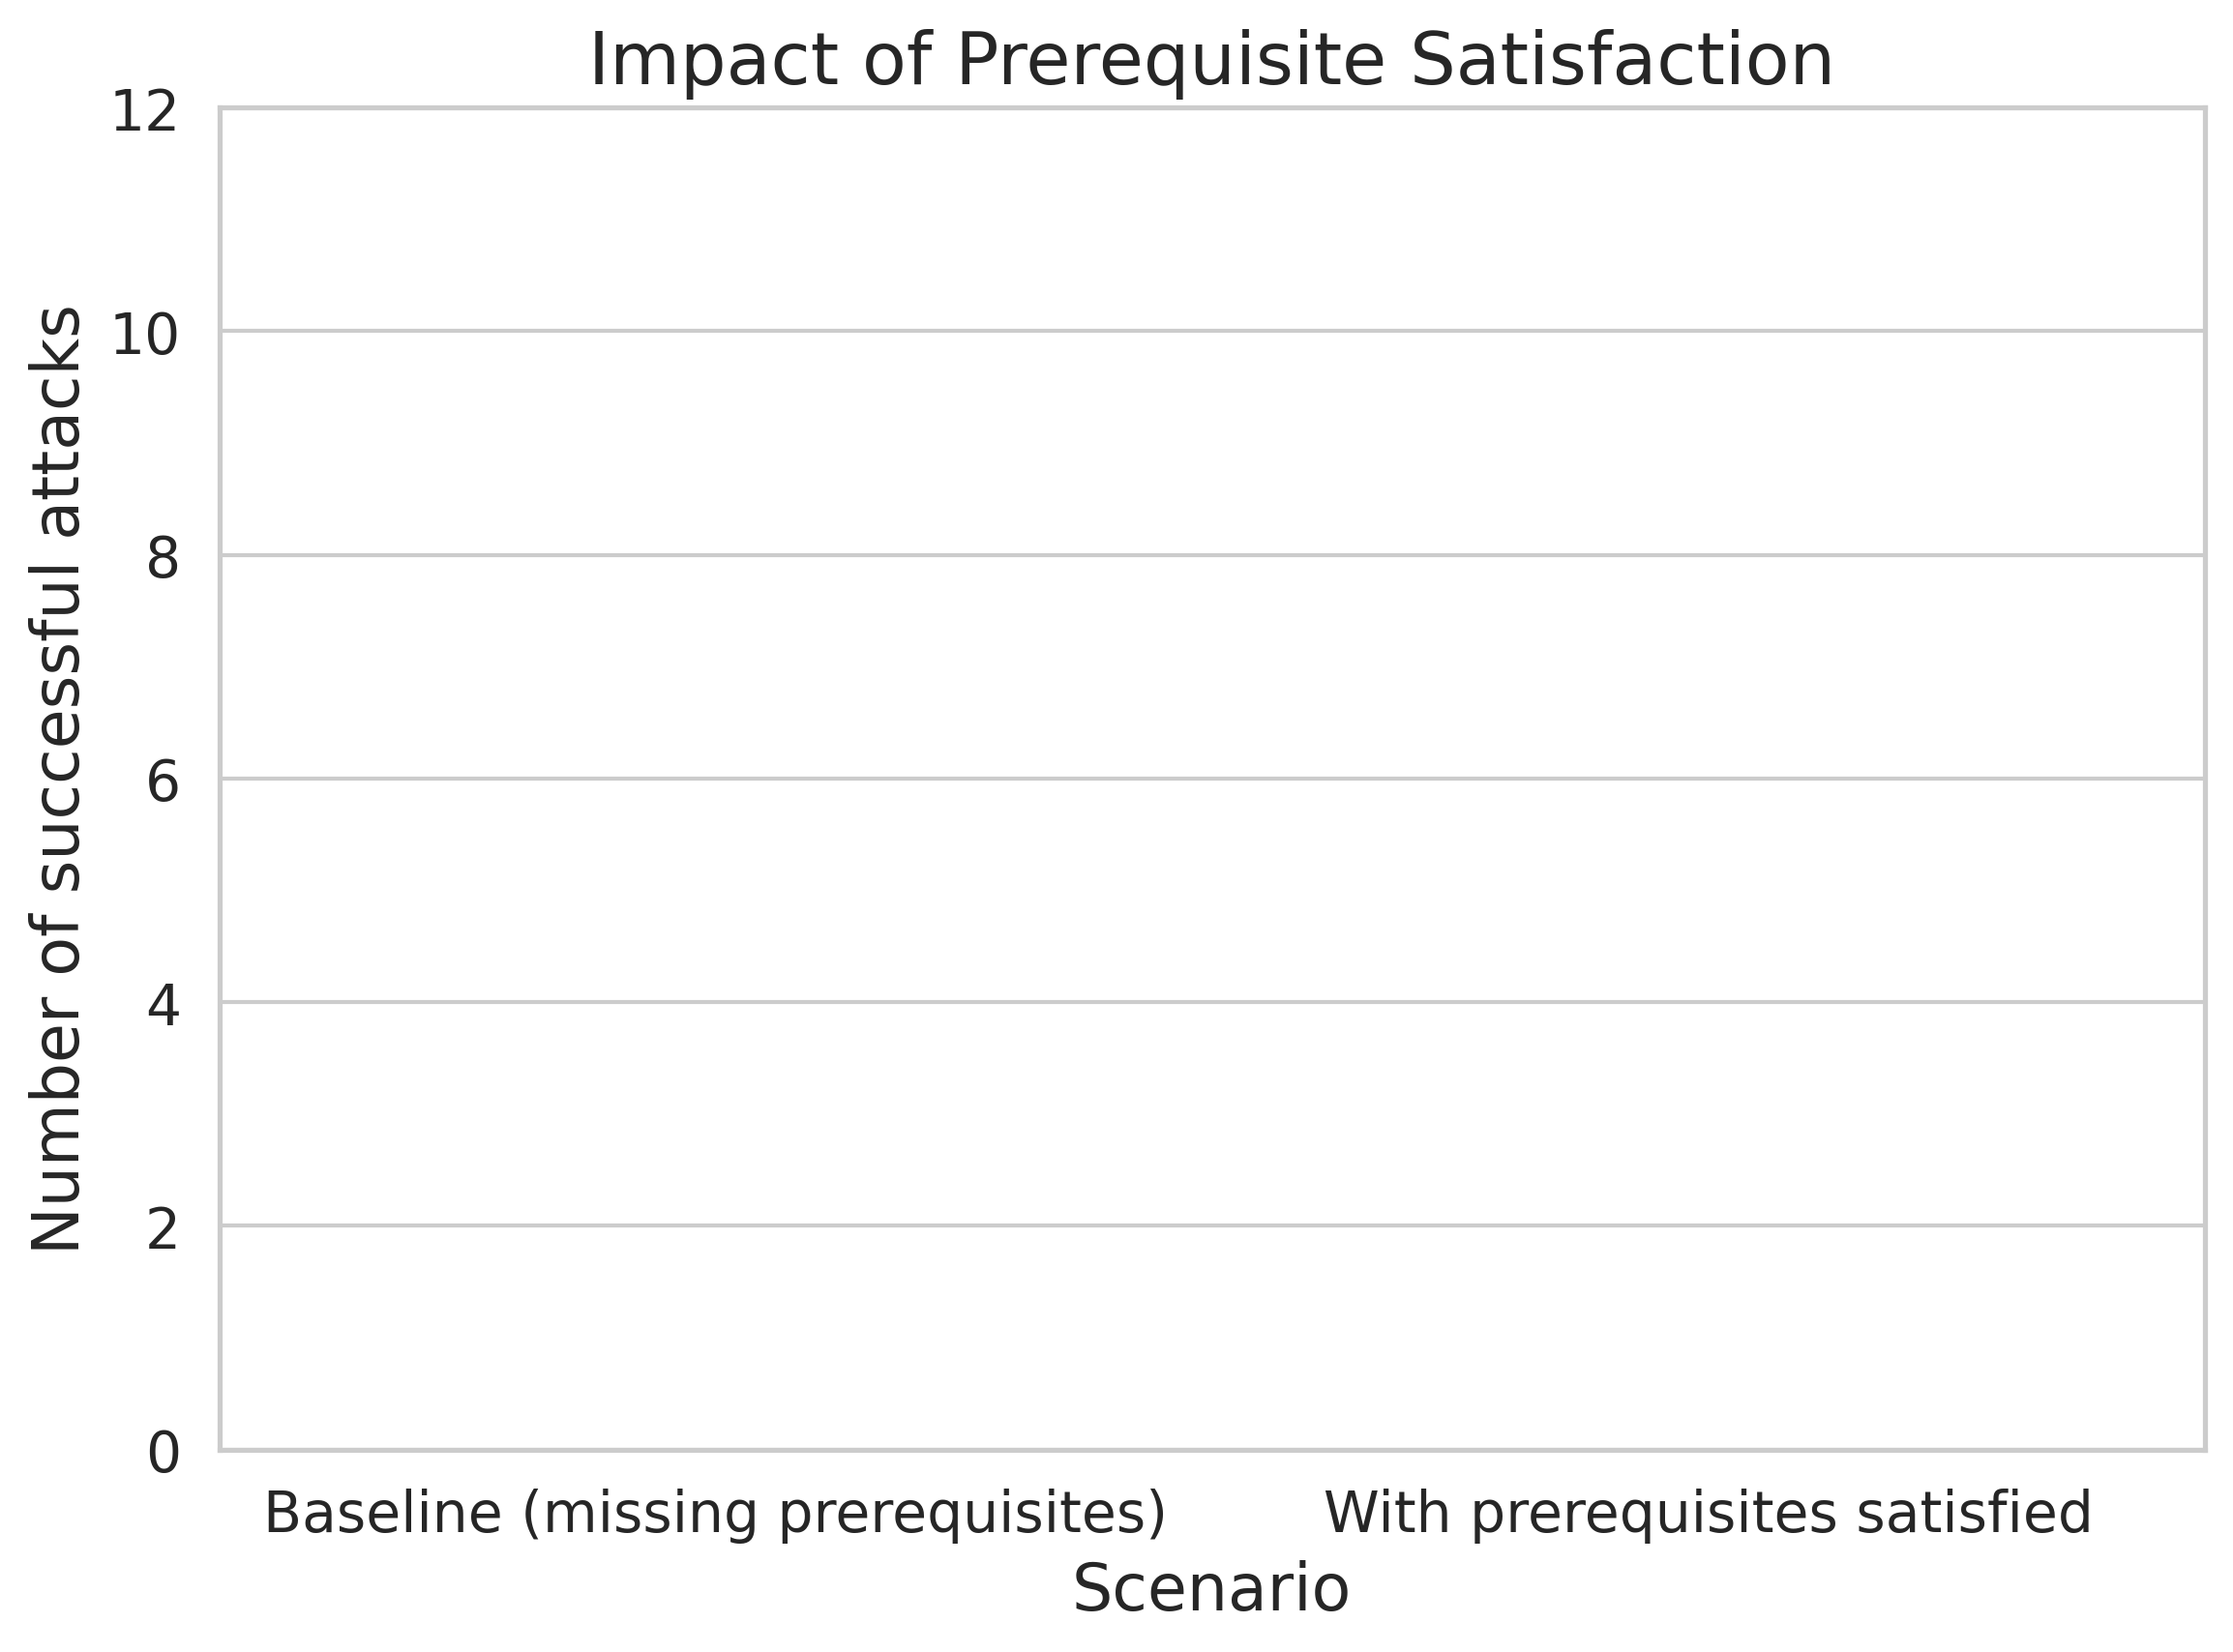

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

summary_df = pd.DataFrame({
    "Scenario": ["Baseline (missing prerequisites)", "With prerequisites satisfied"],
    "Successful Attacks": [sum(base_success.values()), sum(augmented_success.values())]
})

plt.figure(figsize=(8, 6))
sns.barplot(
    data=summary_df,
    x="Scenario",
    y="Successful Attacks"
)

plt.ylabel("Number of successful attacks")
plt.ylim(0, max(12, summary_df["Successful Attacks"].max() * 1.2)) # Adjust ylim dynamically
plt.title("Impact of Prerequisite Satisfaction")

plt.tight_layout()
os.makedirs('/content/results/', exist_ok=True)
plt.savefig("/content/results/fig_6_to_11.png", dpi=300)
plt.show()


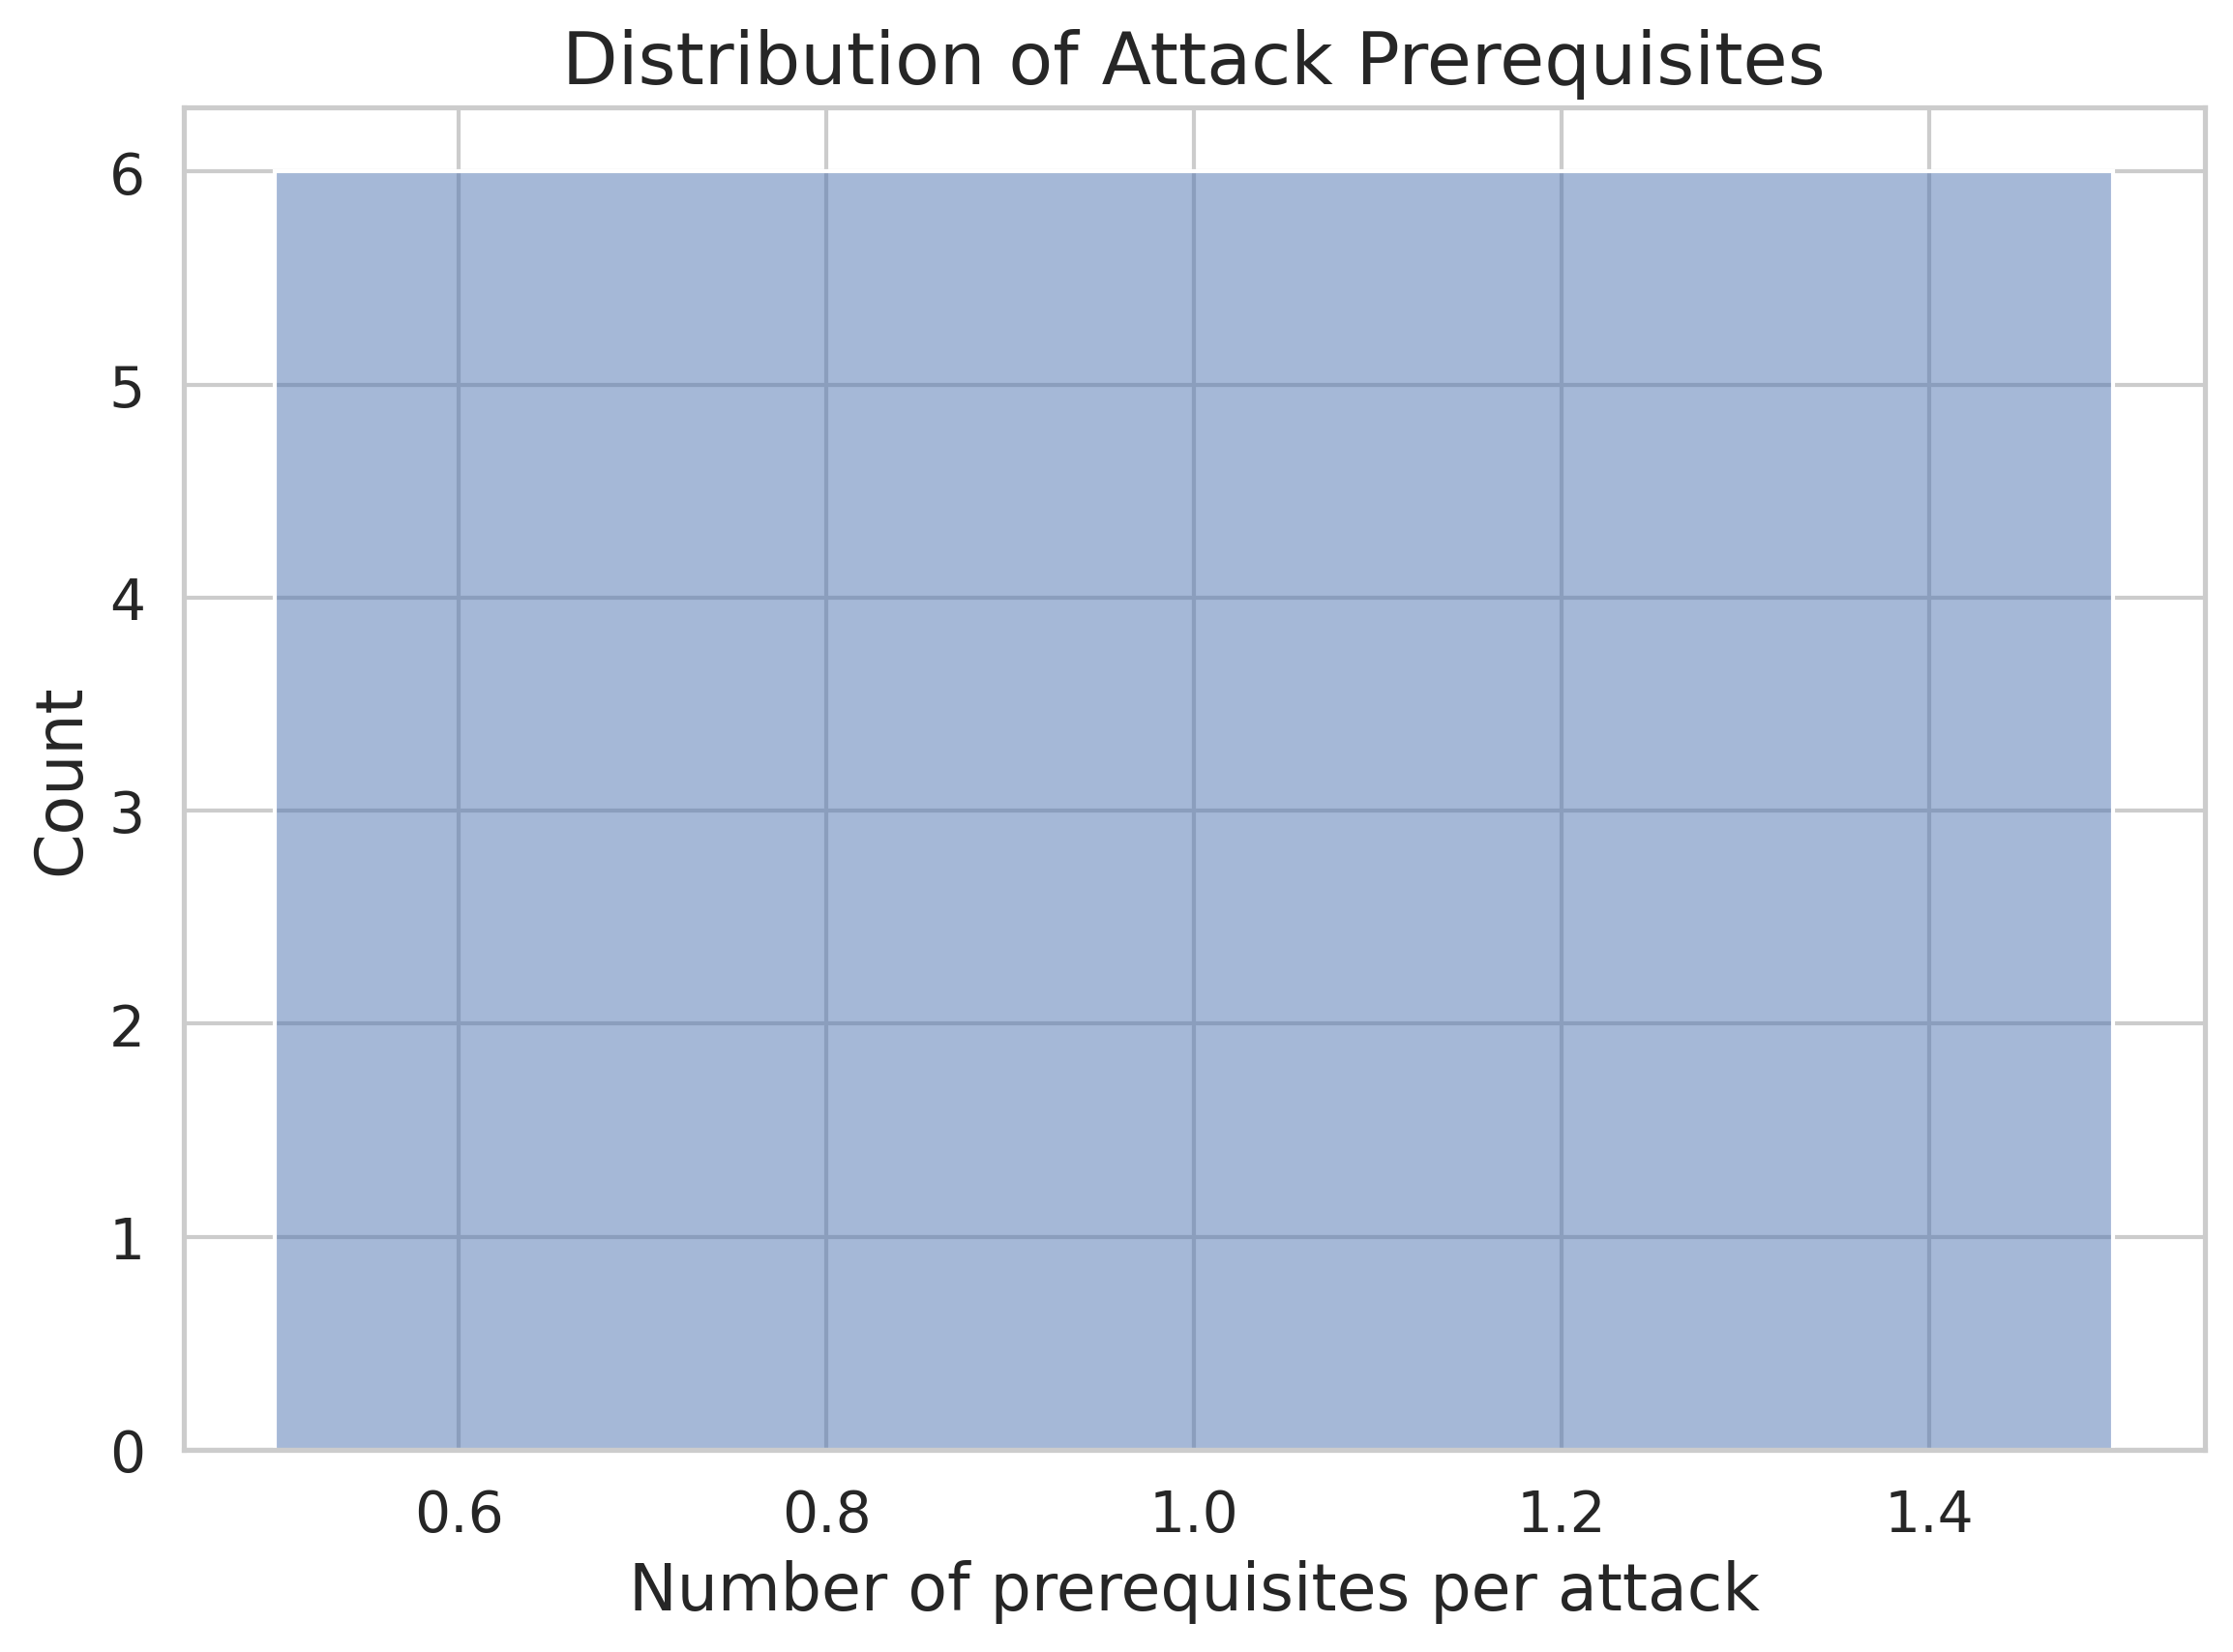

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

prereq_counts = [len(v) for v in prereq_cols.values()]

plt.figure(figsize=(8, 6))
sns.histplot(prereq_counts, bins=len(set(prereq_counts)), kde=True) # Adjust bins for better representation

plt.xlabel("Number of prerequisites per attack")
plt.ylabel("Count")
plt.title("Distribution of Attack Prerequisites")

plt.tight_layout()
os.makedirs('/content/results/', exist_ok=True)
plt.savefig("/content/results/fig_prereq_hist.png", dpi=300)
plt.show()


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set global style for high quality publication plots
sns.set_theme(
    style="whitegrid", # or "darkgrid", "ticks", "dark", "white"
    palette="deep",    # or "pastel", "bright", "dark", "muted", "colorblind"
    font_scale=1.4,    # Increase font size for better readability
    rc={
        "axes.labelsize": 16,
        "axes.titlesize": 18,
        "xtick.labelsize": 14,
        "ytick.labelsize": 14,
        "legend.fontsize": 14,
        "lines.linewidth": 2, # Thicker lines
        "lines.markersize": 8, # Larger markers
        "figure.dpi": 300 # Set default figure DPI for higher resolution
    }
)


In [28]:
# ✅ Verification cell (run once)

import rvprober_code

veh = rvprober_code.VehicleSim()
success, final_state = rvprober_code.simulate_attack(
    veh,
    attack_type='GPS_Spoof',
    intensity=0.6,
    duration=8.0
)

print("Attack success:", success)
print("Final state:", final_state)


Attack success: True
Final state: [0.25 0.   0.   0.5 ]


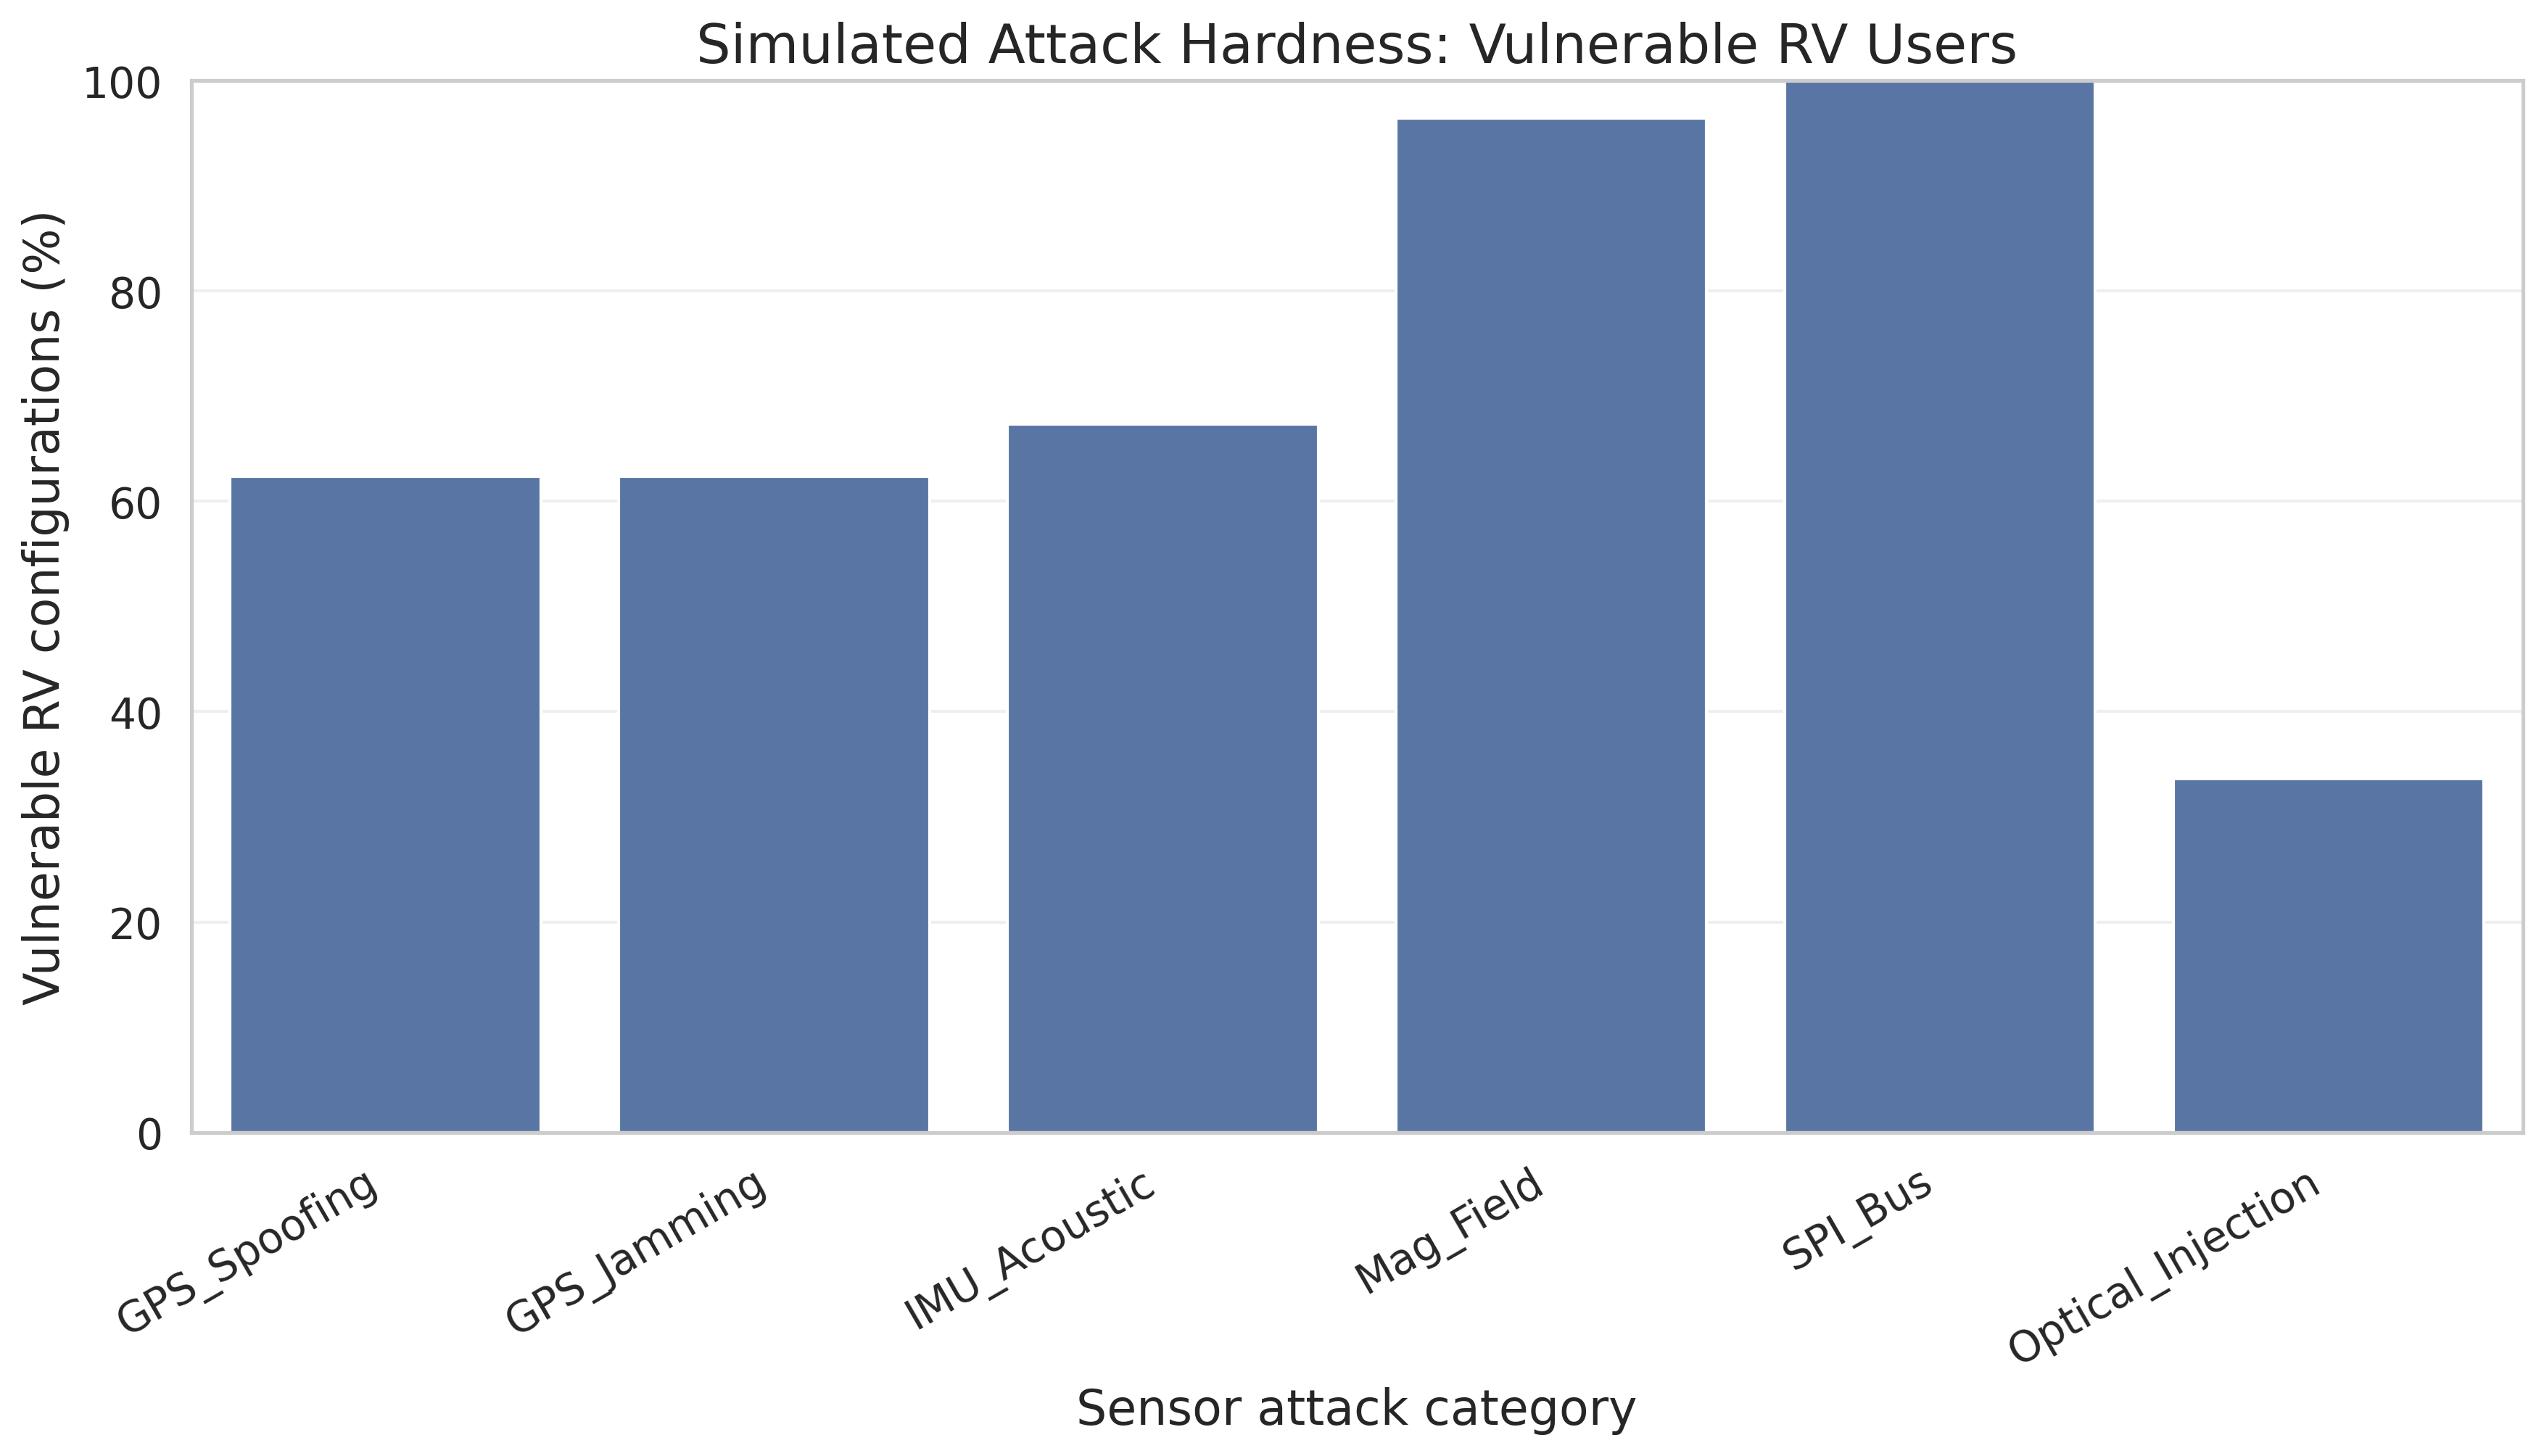

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

attacks_names = list(vulnerability_results.keys())
vulnerabilities_values = [vulnerability_results[a] for a in attacks_names]

plt.figure(figsize=(12,7))
sns.barplot(x=attacks_names, y=vulnerabilities_values)

plt.ylabel("Vulnerable RV configurations (%)")
plt.xlabel("Sensor attack category")
plt.title("Simulated Attack Hardness: Vulnerable RV Users")
plt.ylim(0,100)
plt.grid(axis="y", alpha=0.3)

plt.xticks(rotation=30, ha='right')
plt.tight_layout()

os.makedirs('/content/results/', exist_ok=True)
plt.savefig("/content/results/fig_vulnerability_bar.png", dpi=300)
plt.show()


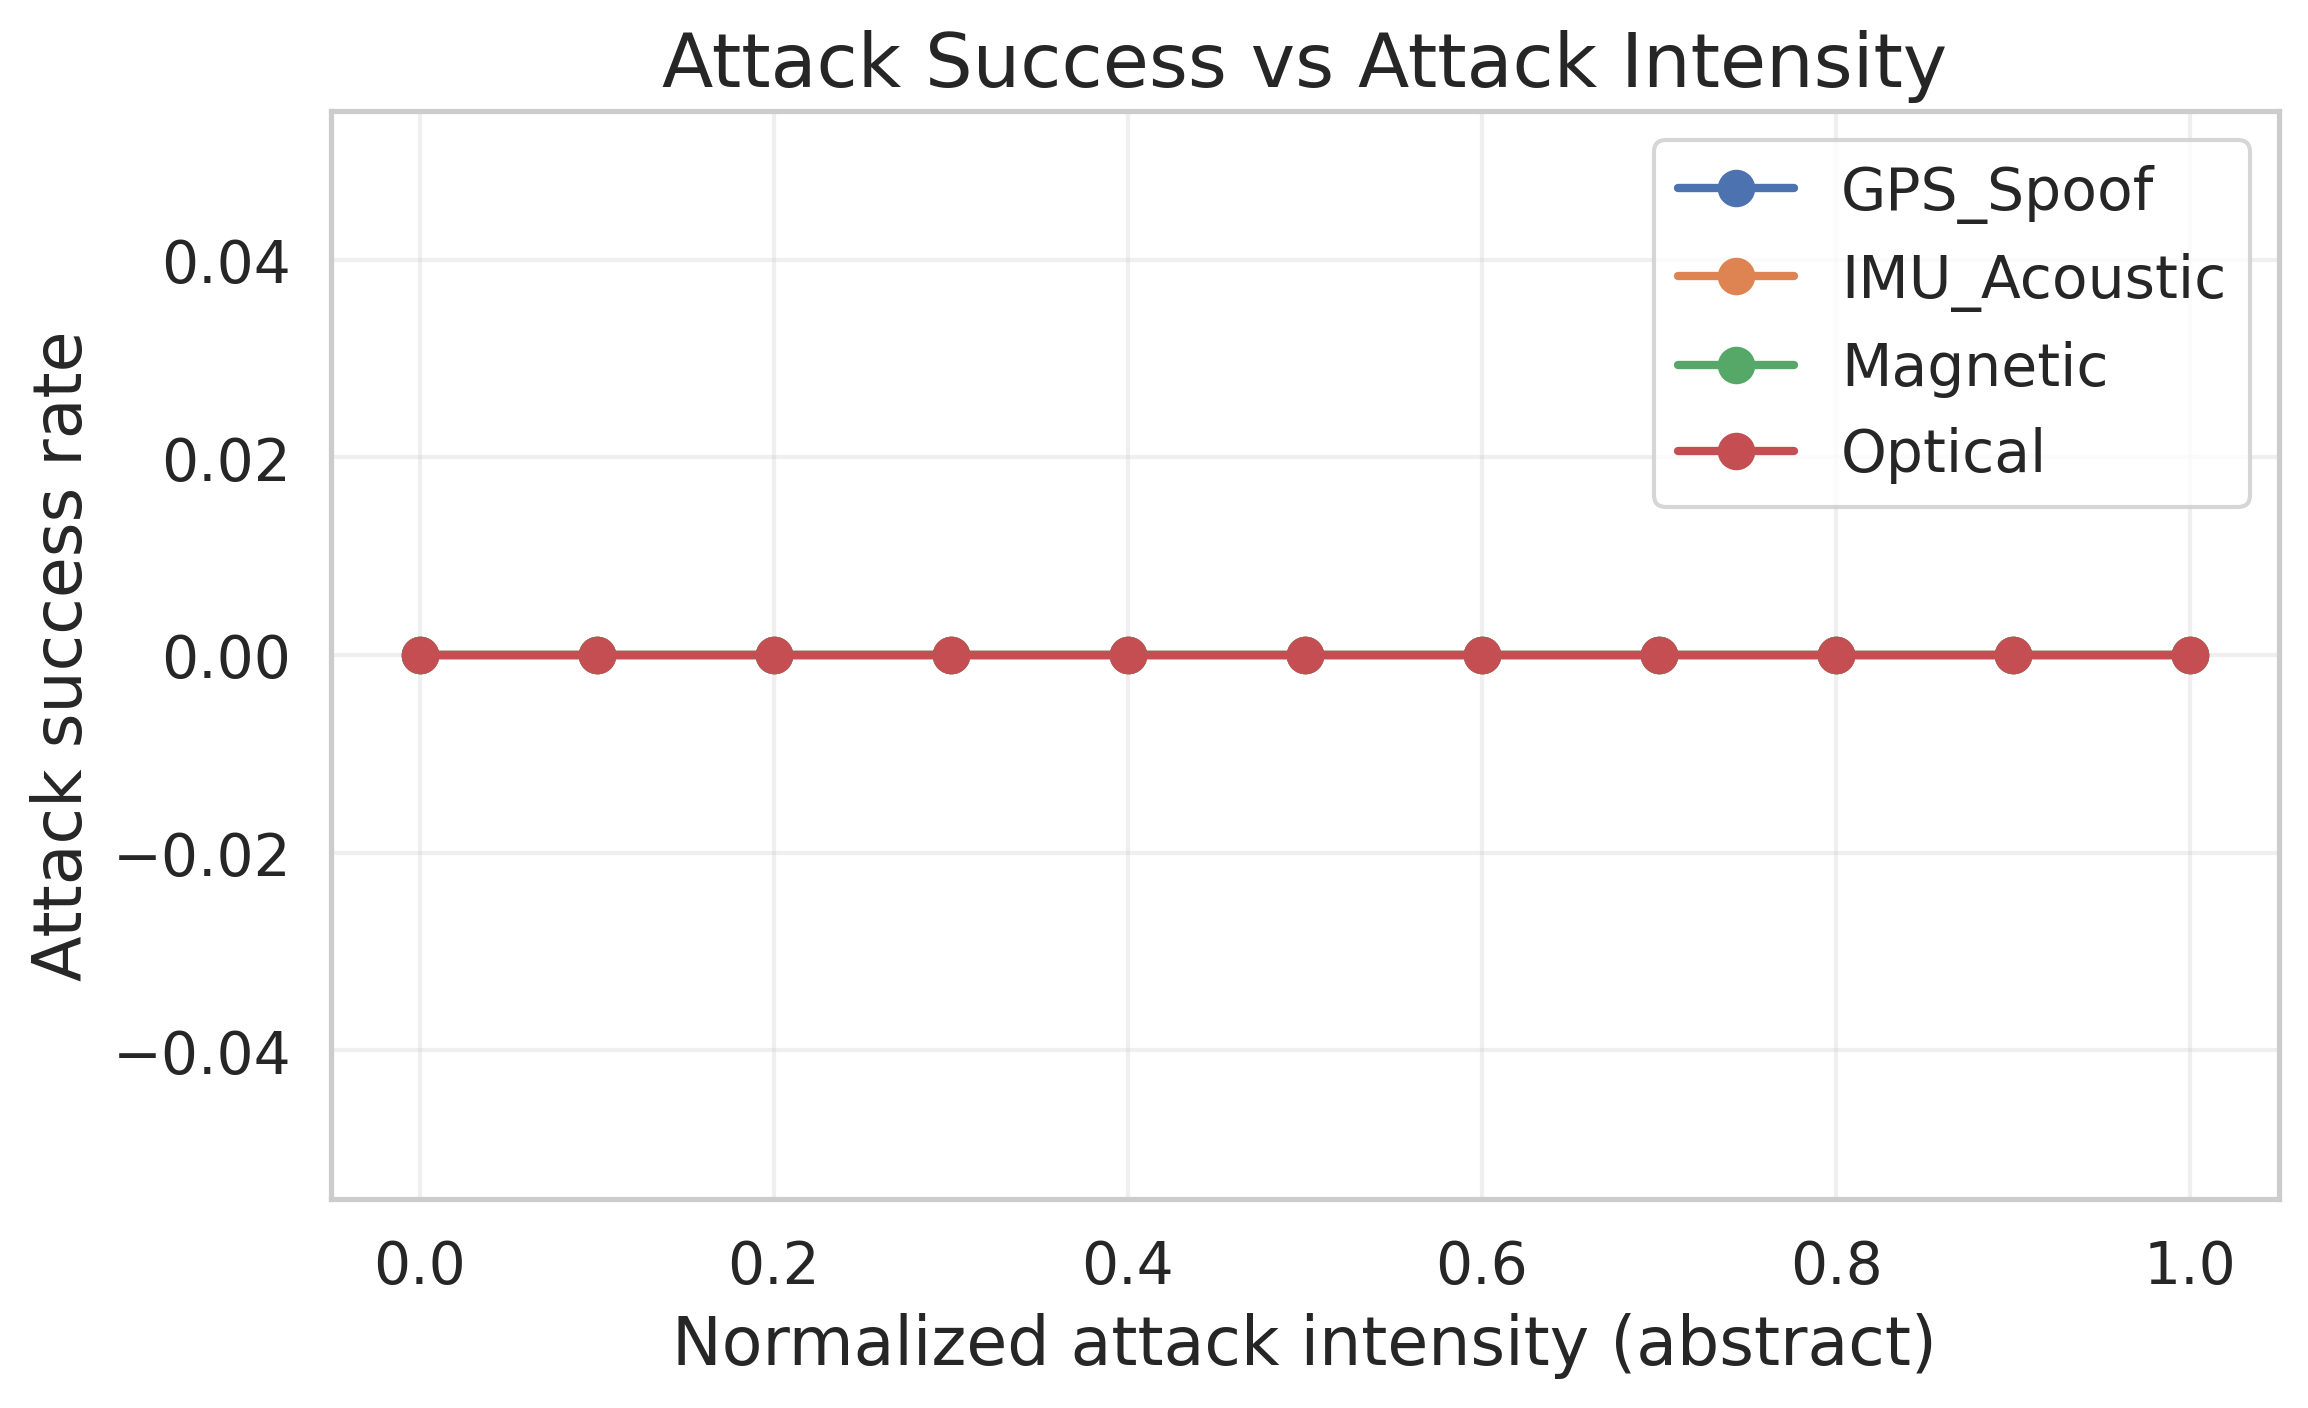

In [31]:
plt.figure(figsize=(8,5))

for attack, success_rate in results.items():
    plt.plot(intensities, success_rate, marker='o', label=attack)

plt.xlabel("Normalized attack intensity (abstract)")
plt.ylabel("Attack success rate")
plt.title("Attack Success vs Attack Intensity")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("/content/results/fig_success_vs_intensity.png", dpi=300)
plt.show()


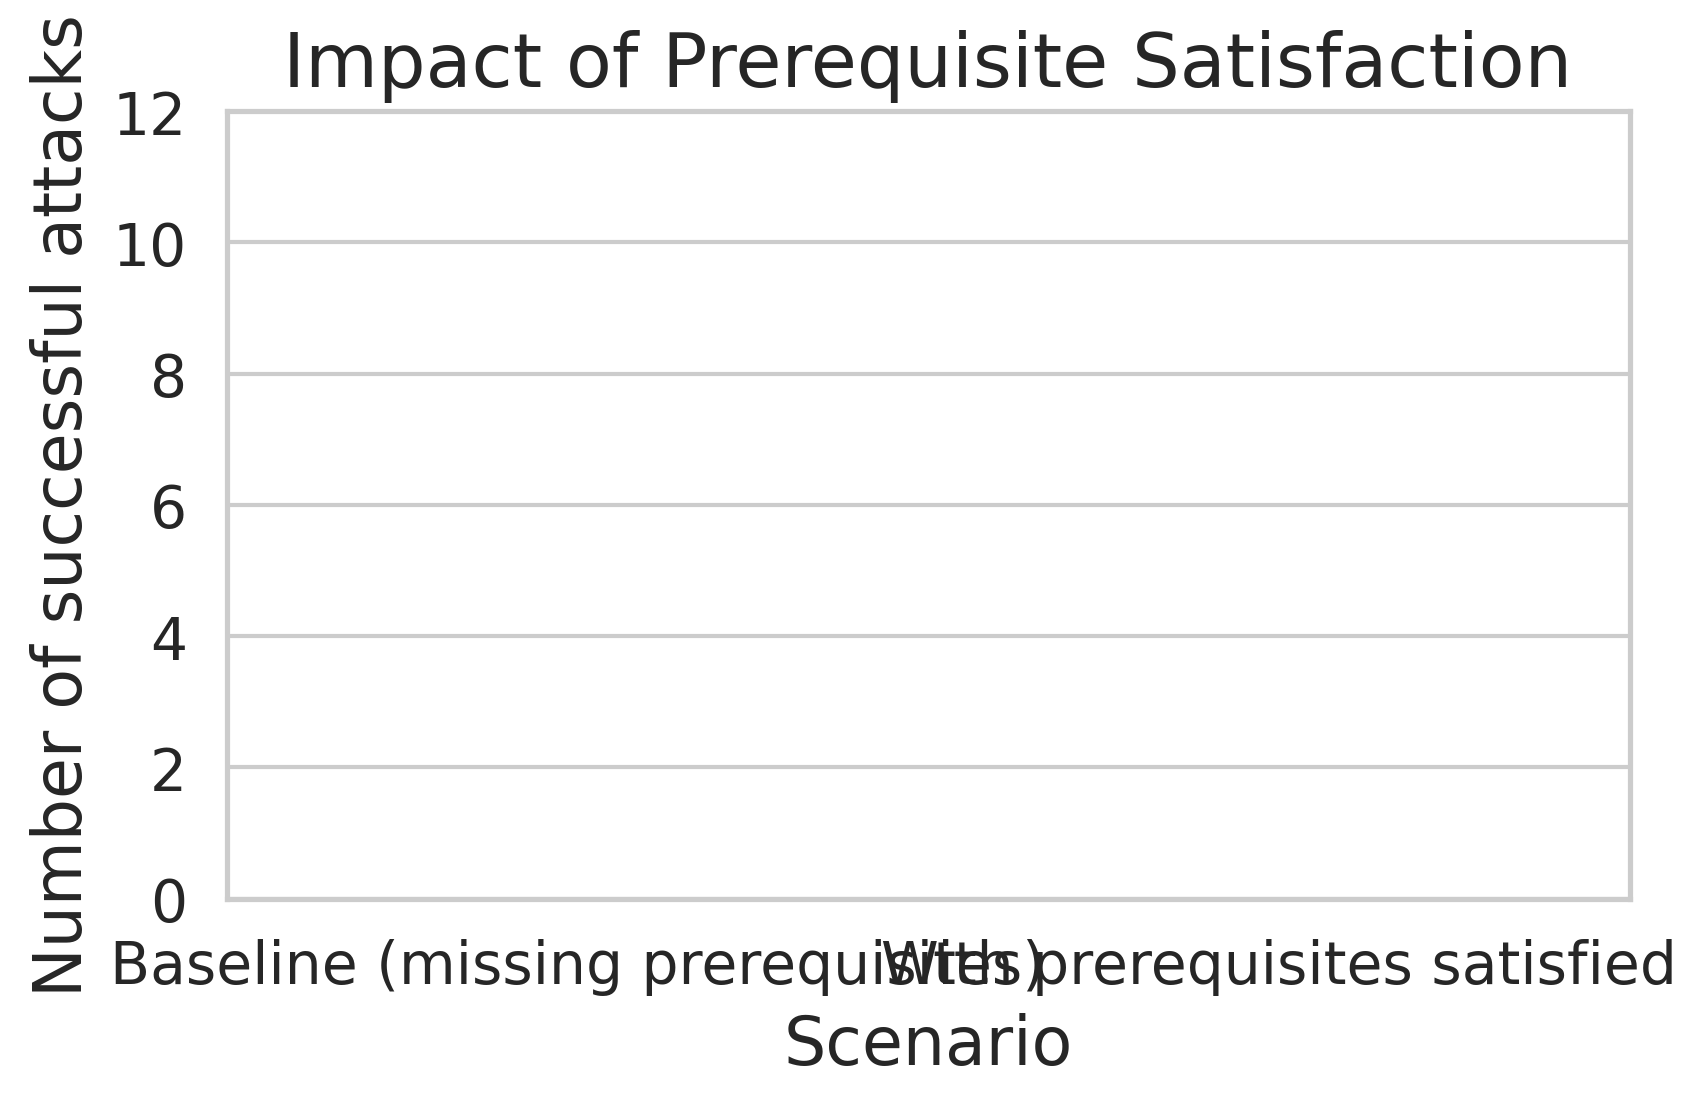

In [32]:
import pandas as pd

summary_df = pd.DataFrame({
    "Scenario": ["Baseline (missing prerequisites)", "With prerequisites satisfied"],
    "Successful Attacks": [sum(base_success.values()), sum(augmented_success.values())]
})

plt.figure(figsize=(6,4))
sns.barplot(
    data=summary_df,
    x="Scenario",
    y="Successful Attacks"
)

plt.ylabel("Number of successful attacks")
plt.ylim(0,12)
plt.title("Impact of Prerequisite Satisfaction")

plt.tight_layout()
plt.savefig("/content/results/fig_6_to_11.png", dpi=300)
plt.show()


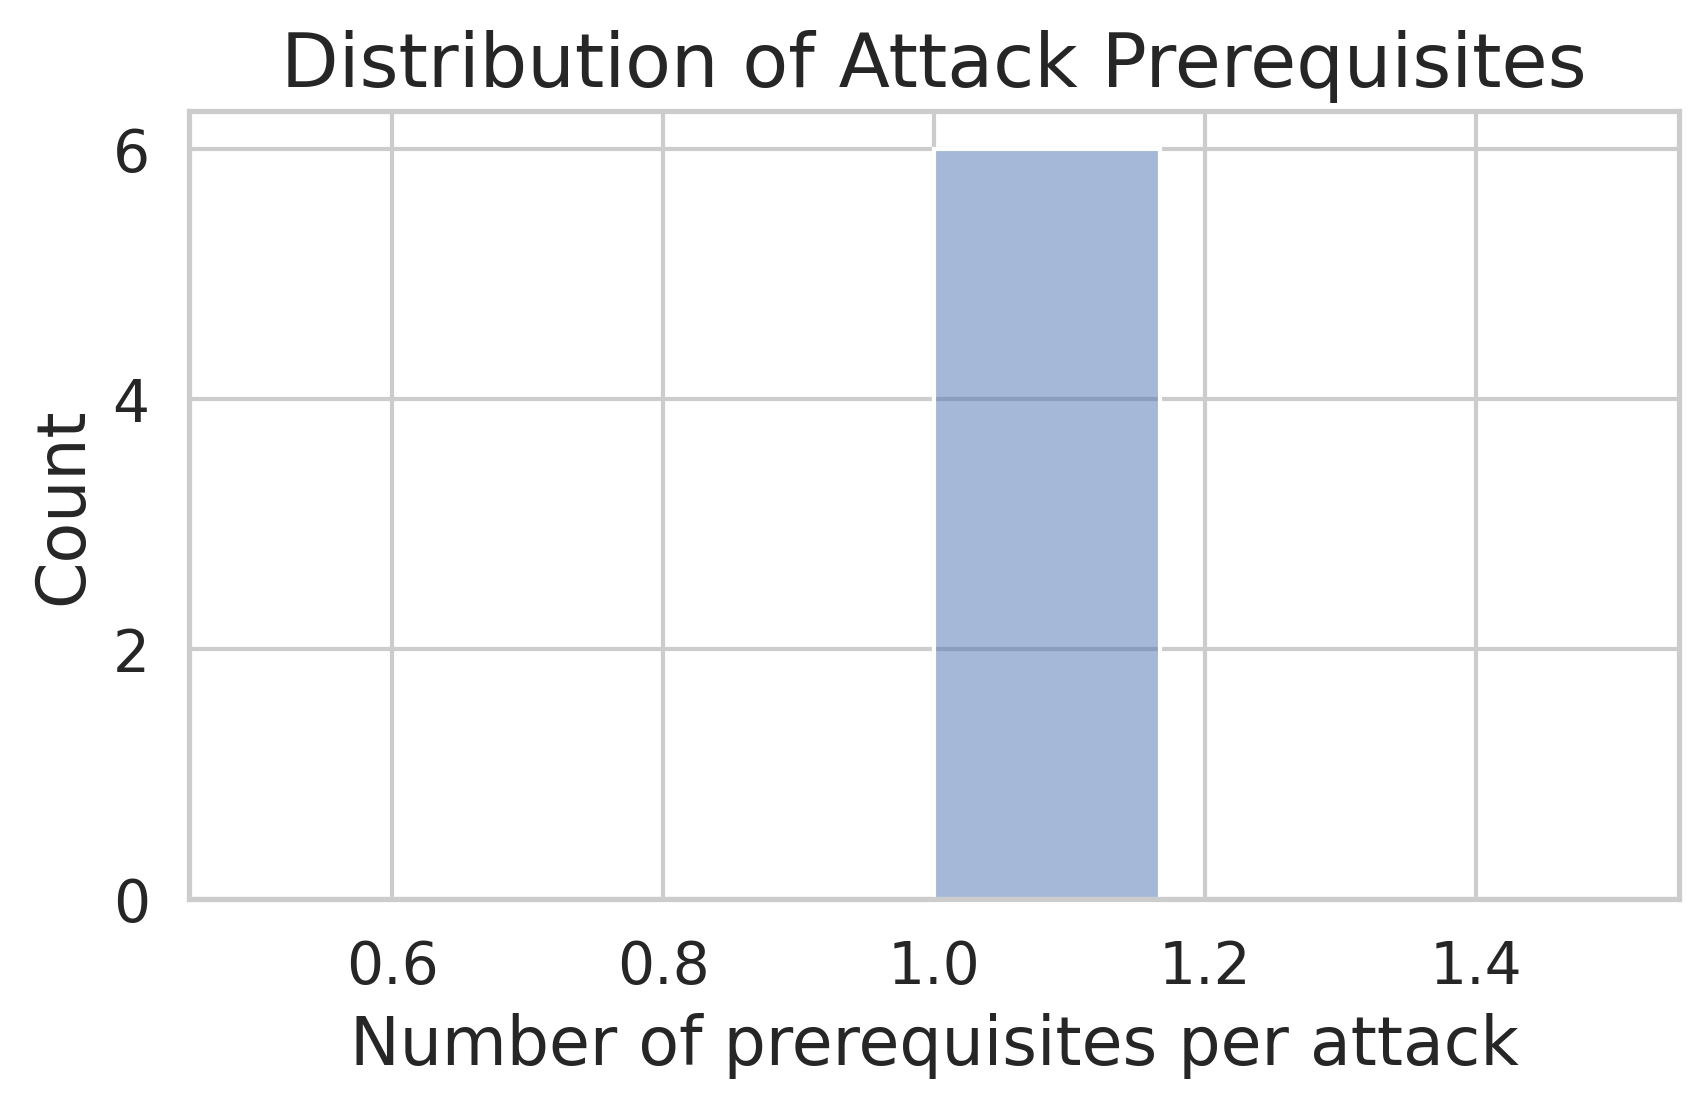

In [33]:
prereq_counts = [len(v) for v in prereq_cols.values()]

plt.figure(figsize=(6,4))
sns.histplot(prereq_counts, bins=6, kde=True)

plt.xlabel("Number of prerequisites per attack")
plt.ylabel("Count")
plt.title("Distribution of Attack Prerequisites")

plt.tight_layout()
plt.savefig("/content/results/fig_prereq_hist.png", dpi=300)
plt.show()


In [34]:
# Install dependencies (Colab)
!pip install numpy scipy matplotlib seaborn pandas

# Create results folder
import os
os.makedirs("/content/results", exist_ok=True)
print("Dependencies installed and /content/results ready.")


Dependencies installed and /content/results ready.


In [35]:
# Imports and global plotting settings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal

# Reproducibility
RNG_SEED = 42
np.random.seed(RNG_SEED)

# Publication-style plotting parameters (suitable for IEEE / NeurIPS)
plt.rcParams.update({
    "figure.dpi": 300,
    "savefig.dpi": 300,
    "font.size": 12,
    "axes.labelsize": 13,
    "axes.titlesize": 14,
    "legend.fontsize": 11,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "font.family": "serif",
})
sns.set_style("whitegrid")
palette = sns.color_palette("tab10")  # 10 distinct colors


In [36]:
# Helper utilities: filtering and integration

def butter_lowpass_filter(data, cutoff_freq, fs, order=4):
    """
    Butterworth low-pass filter applied forward-backward for zero phase distortion.
    - cutoff_freq: normalized frequency (Hz)
    - fs: sampling rate (Hz)
    """
    nyq = 0.5 * fs
    normal_cutoff = cutoff_freq / nyq
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    # filtfilt for zero-phase filtering
    y = signal.filtfilt(b, a, data, method="pad")
    return y

def unwrap_phase_deg(angle_deg):
    """Utility to unwrap degree angles into a continuous signal (like numpy.unwrap but for degrees)."""
    return np.rad2deg(np.unwrap(np.deg2rad(angle_deg)))

def save_and_show(fig, filename_png, filename_pdf=None):
    """Save figure high-resolution and display inline."""
    out_png = f"/content/results/{filename_png}"
    fig.savefig(out_png, dpi=300, bbox_inches='tight')
    if filename_pdf:
        out_pdf = f"/content/results/{filename_pdf}"
        fig.savefig(out_pdf, bbox_inches='tight')  # vector-friendly PDF
    plt.show()
    print(f"Saved: {out_png}" + (f", /content/results/{filename_pdf}" if filename_pdf else "" ))


In [37]:
# Simulation parameters
fs = 100.0           # sampling frequency (Hz)
T = 40.0             # total time (s)
t = np.arange(0, T, 1.0/fs)
n = len(t)

# True vehicle trajectories (example maneuver): roll oscillation and altitude profile
true_roll_deg = 5.0 * np.sin(0.2 * 2*np.pi * t) + 2.0 * np.sin(0.8 * 2*np.pi * t)  # deg
true_alt = 50.0 + 0.5 * np.sin(0.05 * 2*np.pi * t) + 0.2 * np.sin(0.3 * 2*np.pi * t) # meters

# Sensor noise parameters (abstract, publication-safe)
gyro_noise_std = 0.5   # deg/sec noise
gyro_bias = 0.0

baro_noise_std = 0.15
gps_alt_noise_std = 0.5

# Define abstract attack perturbation models (non-actionable): additive normalized-scaled waveforms
def imu_acoustic_perturbation(t, intensity=0.0, freq_hz=30.0):
    """
    Abstract acoustic-like perturbation: narrowband sinusoid scaled by intensity [0,1].
    Note: freq_hz is chosen only for simulation variety and NOT a real-world guidance.
    """
    return intensity * 10.0 * np.sin(2*np.pi*freq_hz*t)  # degrees/sec magnitude scaled abstractly

def mag_bias_perturbation(t, intensity=0.0):
    """Slow varying bias to simulate magnetometer drift (abstract)."""
    return intensity * 10.0 * np.sin(2*np.pi*0.02*t)  # degrees bias

# Test cases definition (you can add more)
test_cases = {
    "baseline": {"imu_intensity": 0.0, "mag_intensity": 0.0},
    "acoustic_low": {"imu_intensity": 0.2, "mag_intensity": 0.0},
    "acoustic_high": {"imu_intensity": 0.7, "mag_intensity": 0.0},
    "magnetic_bias": {"imu_intensity": 0.0, "mag_intensity": 0.6},
}

# Pre-allocate dataset dictionary
sim_data = {}

for name, params in test_cases.items():
    # True angular rate (deg/sec) = derivative of true_roll
    true_roll_rad = np.deg2rad(true_roll_deg)
    true_rate_rad = np.gradient(true_roll_rad, 1.0/fs)
    true_rate_deg = np.rad2deg(true_rate_rad)

    # Base gyroscope measurement (angular rate) with noise
    gyro_meas = true_rate_deg + np.random.normal(0, gyro_noise_std, size=n) + gyro_bias

    # Add abstract IMU acoustic perturbation to gyro measurements (if any)
    if params["imu_intensity"] > 0:
        gyro_meas = gyro_meas + imu_acoustic_perturbation(t, intensity=params["imu_intensity"], freq_hz=27.0)

    # Simulate magnetometer-derived roll (degrees) and add bias perturbation
    mag_roll = true_roll_deg + np.random.normal(0, 0.7, size=n)  # magnetometer noisy roll proxy
    if params["mag_intensity"] > 0:
        mag_roll = mag_roll + mag_bias_perturbation(t, intensity=params["mag_intensity"])

    # Altitude sensors
    baro = true_alt + np.random.normal(0, baro_noise_std, size=n)
    gps_alt = true_alt + np.random.normal(0, gps_alt_noise_std, size=n)
    # Complementary filter for altitude estimate
    alpha = 0.98  # weight for high-rate sensor (baro), low-rate correction from GPS
    fused_alt = np.zeros_like(true_alt)
    fused_alt[0] = baro[0]
    for i in range(1, n):
        fused_alt[i] = alpha * (fused_alt[i-1] + (baro[i] - baro[i-1])) + (1-alpha) * gps_alt[i]

    # Integrate gyro to compute roll estimate (simple integration of rate)
    # Use trapezoidal integration, then apply smoothing filter to emulate sensor fusion
    roll_est_from_gyro = np.cumsum((gyro_meas) * (1.0/fs))  # deg (integration)
    # Correct integration offset to align with true mean
    roll_est_from_gyro = roll_est_from_gyro - np.mean(roll_est_from_gyro) + np.mean(true_roll_deg)

    # Low-pass filter the integrated roll (emulate filters/EKF smoothing)
    roll_est_filtered = butter_lowpass_filter(roll_est_from_gyro, cutoff_freq=2.0, fs=fs, order=4)

    # Save data for this test case
    sim_data[name] = {
        "t": t,
        "true_roll_deg": true_roll_deg,
        "true_alt": true_alt,
        "gyro_meas": gyro_meas,
        "mag_roll": mag_roll,
        "baro": baro,
        "gps_alt": gps_alt,
        "fused_alt": fused_alt,
        "roll_est_filtered": roll_est_filtered,
    }

print("Simulation complete: generated data for test cases:", list(sim_data.keys()))


Simulation complete: generated data for test cases: ['baseline', 'acoustic_low', 'acoustic_high', 'magnetic_bias']


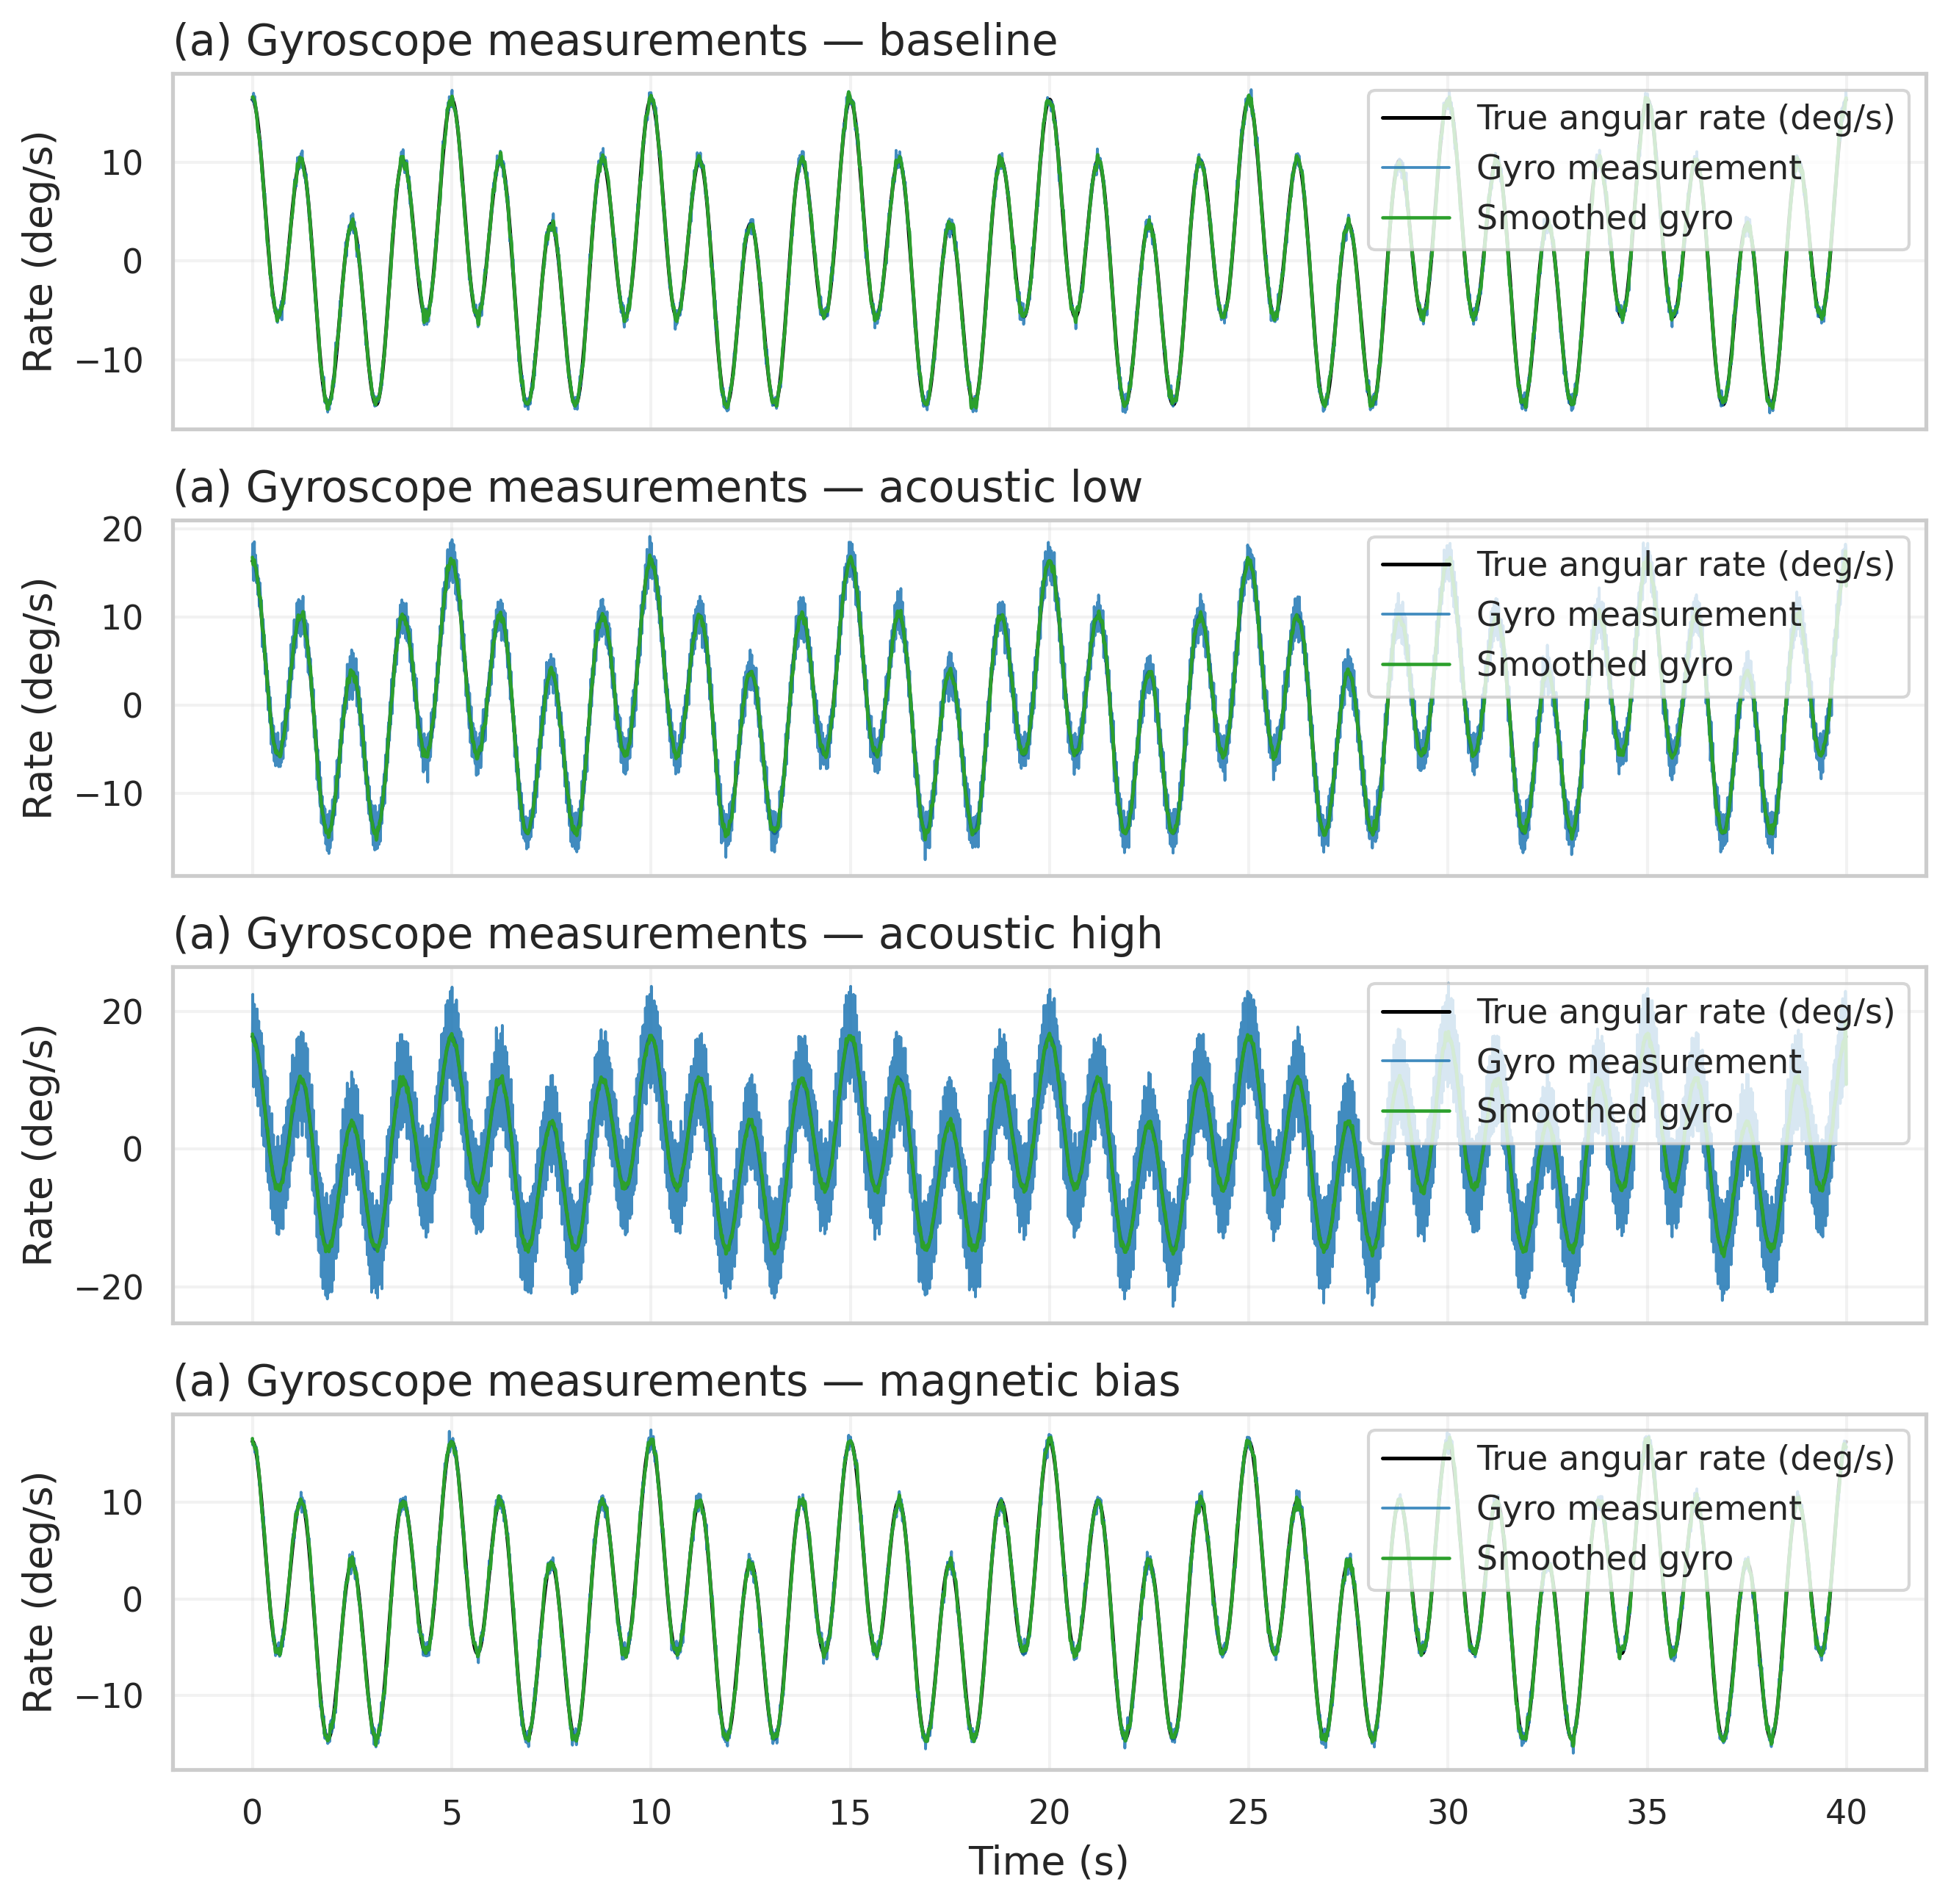

Saved: /content/results/fig_gyro_measurements.png, /content/results/fig_gyro_measurements.pdf


In [38]:
# Figure (a) — Gyroscope measurements across test cases
fig, axes = plt.subplots(len(sim_data), 1, figsize=(9, 2.2 * len(sim_data)), sharex=True)

for ax, (name, data) in zip(axes, sim_data.items()):
    ax.plot(data["t"], np.rad2deg(np.gradient(np.deg2rad(data["true_roll_deg"]), 1.0/fs)),
            color="black", lw=1.2, label="True angular rate (deg/s)")
    ax.plot(data["t"], data["gyro_meas"], color=palette[0], alpha=0.85, lw=0.9, label="Gyro measurement")
    # add a smoothed version for visual clarity
    smooth = butter_lowpass_filter(data["gyro_meas"], cutoff_freq=20.0, fs=fs, order=4)
    ax.plot(data["t"], smooth, color=palette[2], lw=1.1, label="Smoothed gyro")

    ax.set_ylabel("Rate (deg/s)")
    ax.set_title(f"(a) Gyroscope measurements — {name.replace('_',' ')}", loc='left')
    ax.grid(True, alpha=0.25)
    ax.legend(loc="upper right")

axes[-1].set_xlabel("Time (s)")
plt.tight_layout()
save_and_show(fig, "fig_gyro_measurements.png", "fig_gyro_measurements.pdf")


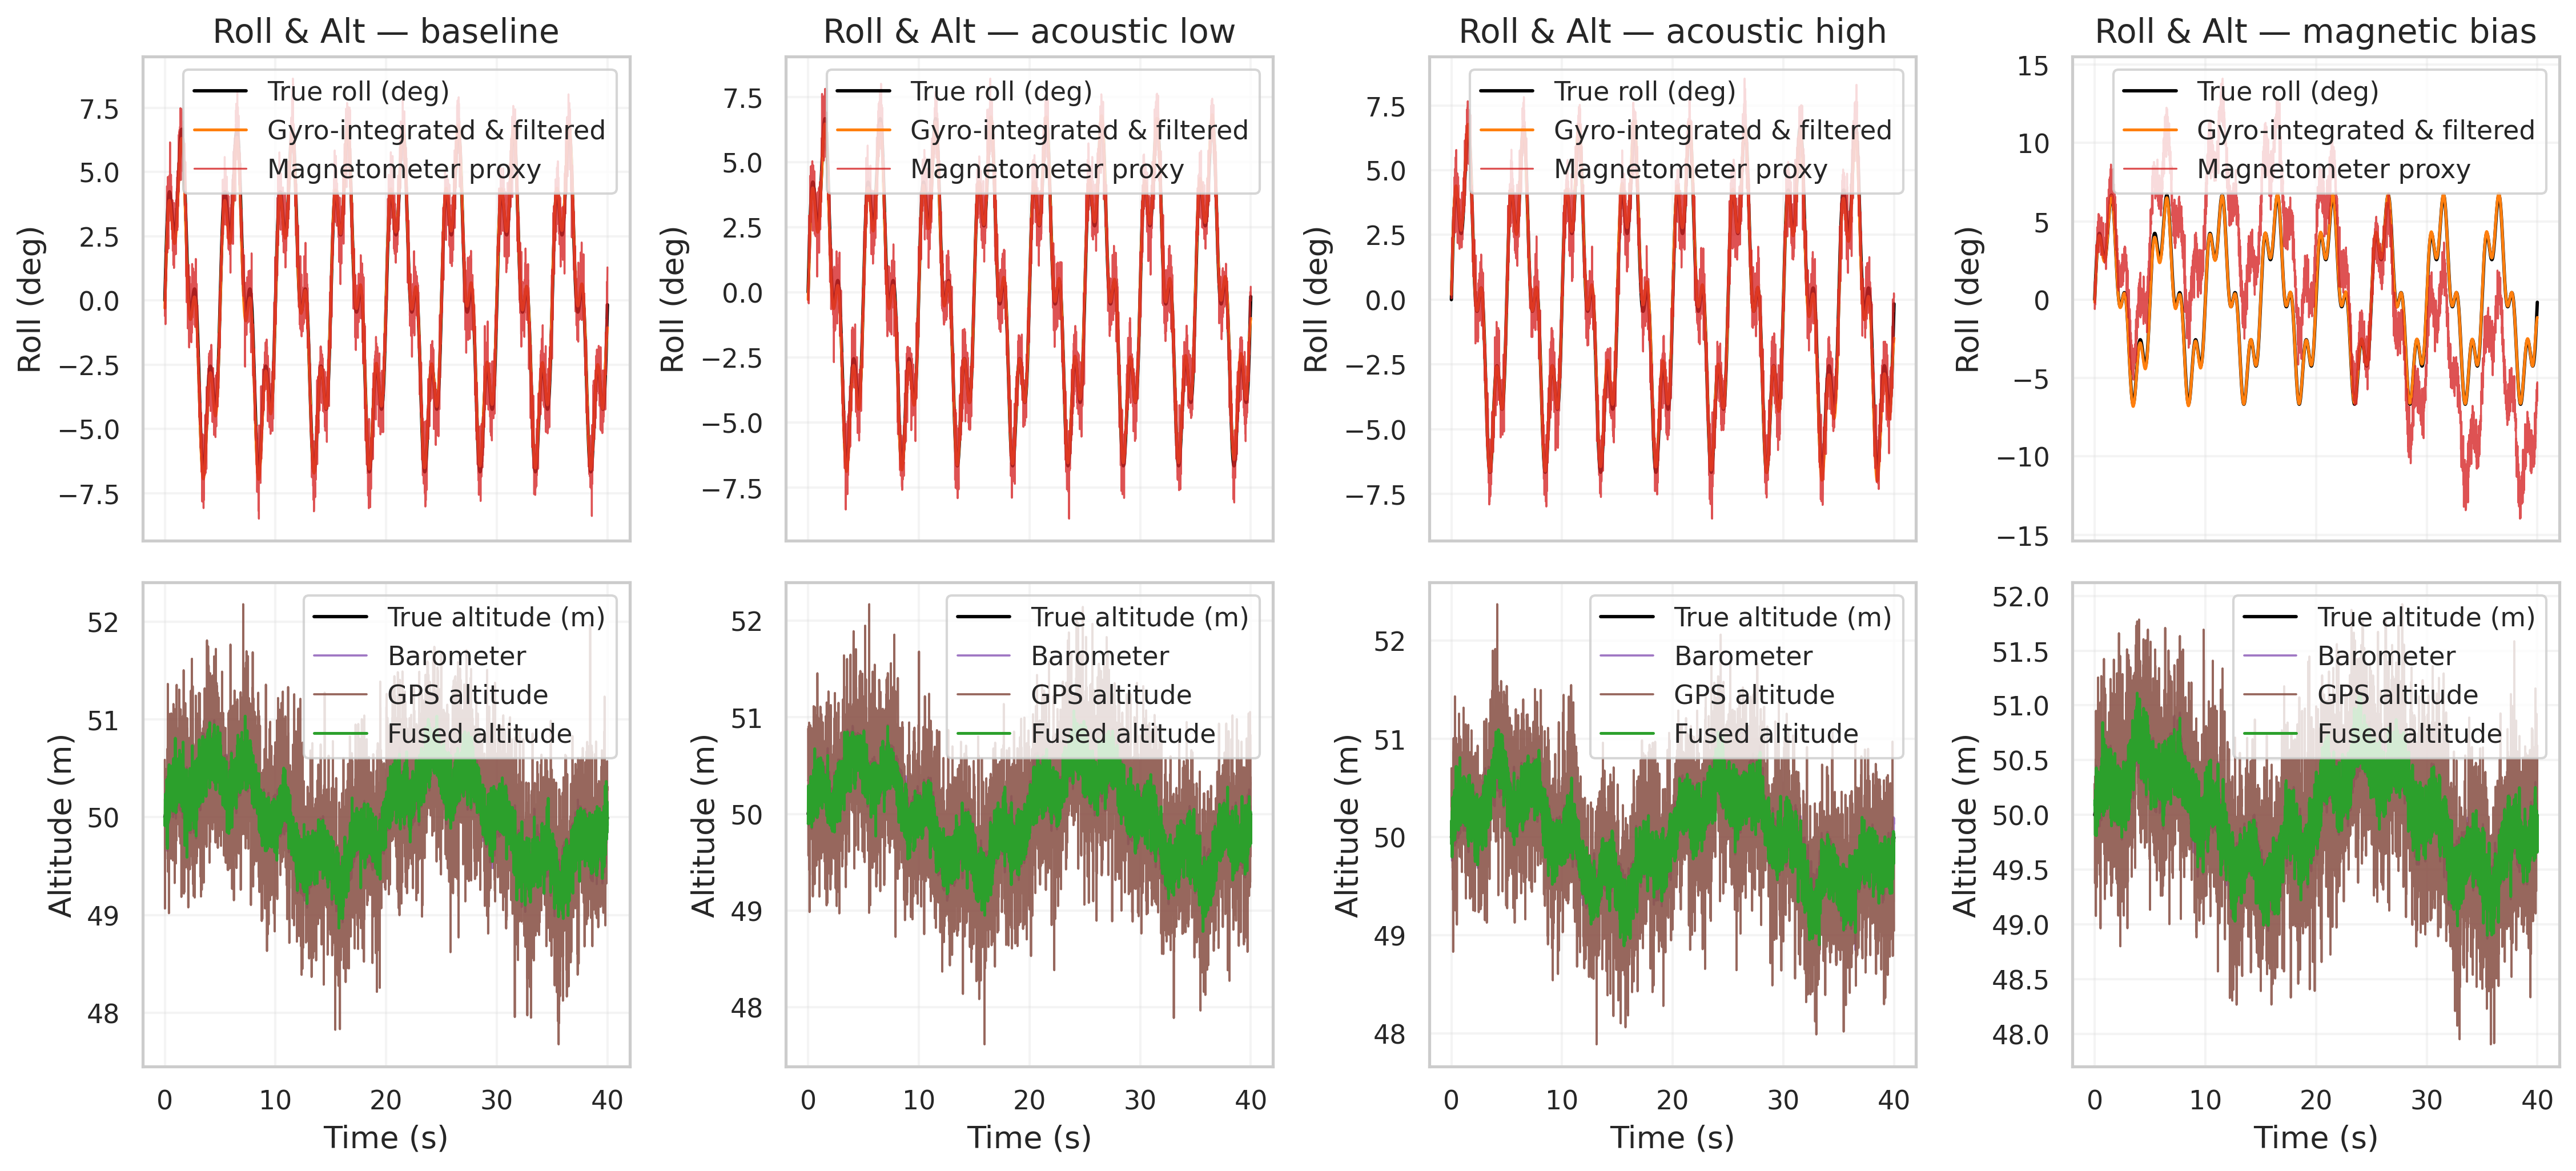

Saved: /content/results/fig_roll_and_altitude.png, /content/results/fig_roll_and_altitude.pdf


In [39]:
# Figure (b) — Roll angle (top) and Altitude (bottom) across test cases in columns
n_cases = len(sim_data)
fig, axes = plt.subplots(2, n_cases, figsize=(3.8*n_cases, 7), sharex='col')

for col_idx, (name, data) in enumerate(sim_data.items()):
    # Top: Roll angle
    ax_roll = axes[0, col_idx] if n_cases > 1 else axes[0]
    ax_roll.plot(data["t"], data["true_roll_deg"], color="black", lw=1.4, label="True roll (deg)")
    ax_roll.plot(data["t"], data["roll_est_filtered"], color=palette[1], lw=1.2, label="Gyro-integrated & filtered")
    ax_roll.plot(data["t"], data["mag_roll"], color=palette[3], lw=0.8, alpha=0.8, label="Magnetometer proxy")
    ax_roll.set_title(f"Roll & Alt — {name.replace('_',' ')}")
    ax_roll.set_ylabel("Roll (deg)")
    ax_roll.legend(loc="upper right")
    ax_roll.grid(alpha=0.2)

    # Bottom: Altitude
    ax_alt = axes[1, col_idx] if n_cases > 1 else axes[1]
    ax_alt.plot(data["t"], data["true_alt"], color="black", lw=1.4, label="True altitude (m)")
    ax_alt.plot(data["t"], data["baro"], color=palette[4], lw=0.9, alpha=0.9, label="Barometer")
    ax_alt.plot(data["t"], data["gps_alt"], color=palette[5], lw=0.9, alpha=0.9, label="GPS altitude")
    ax_alt.plot(data["t"], data["fused_alt"], color=palette[2], lw=1.2, label="Fused altitude")
    ax_alt.set_ylabel("Altitude (m)")
    ax_alt.set_xlabel("Time (s)")
    ax_alt.legend(loc="upper right")
    ax_alt.grid(alpha=0.2)

plt.tight_layout()
save_and_show(fig, "fig_roll_and_altitude.png", "fig_roll_and_altitude.pdf")
